# Project: US county-level sociodemographic and health resource data (2018-2019)

# Step 1: Import Essential Libraries 

In [2]:
# Libraries specialized "expert kits" to plug into Python essential for EDA.
import requests
import os
from pathlib import Path
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import json
from numpy._core.defchararray import upper
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import f_classif, SelectKBest
import pickle # -- Binary (unreadable by humans) -- Can save almost any Python object -- Very fast for complex objects --
import math
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import f_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.linear_model import Ridge, Lasso
from sklearn.linear_model import RidgeCV, LassoCV


# Step 2: Problem Statement / Data Collection
## 2.1 Description of the Problem

    Sociodemographic and health resource data have been collected by county in the United States and we want to find out if there is any relationship between health resources and sociodemographic data.
    To do this, you need to set a target variable (health-related) to conduct the analysis: The TARGET --> **Heart disease_prevalence**


## 2.2 Inicitial Loading and Inspection

In [3]:
def setup_project_structure(base_path, subfolders):
    """Creates a standard data science directory tree."""
    for folder in subfolders:
        folder_path = Path(base_path) / folder
        folder_path.mkdir(parents=True, exist_ok=True)
    print(f"Project structure initialized in: {base_path}")

def download_dataset_to_raw(url, full_path):
    """Downloads a file to a specific path."""
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()

        with open(full_path, 'wb') as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:
                    file.write(chunk)
            
        print(f"Download successful! Saved to: {full_path}")
        return True
    except Exception as e:
        print(f"Download failed: {e}")
        return False

    except requests.exceptions.RequestException as e:
        print(f"An error occurred during the download: {e}")
        return False
    
# --- CONFIGURATION ---
BASE_DIR = "../data"
FOLDERS = ["raw", "processed", "interim"]
DATA_URL = "https://breathecode.herokuapp.com/asset/internal-link?id=418&path=demographic_health_data.csv"
TARGET_FILE = "demographic_health_data.csv"

# EXECUTION
# Build the whole house
setup_project_structure(BASE_DIR, FOLDERS)

# Put the data in the 'raw' room
RAW_FILE_PATH = Path(BASE_DIR) / "raw" / TARGET_FILE
download_dataset_to_raw(DATA_URL, RAW_FILE_PATH)

Project structure initialized in: ../data
Download successful! Saved to: ../data/raw/demographic_health_data.csv


True

In [4]:
# Define the full path again for reading
try:
    df = pd.read_csv(RAW_FILE_PATH, sep= None, engine= 'python')
    print("\nDataset loaded successfully into a DataFrame:")
    print(tabulate(df.head(), headers= "keys", tablefmt= "psql"))
except FileNotFoundError:
    print(f"\nError: File not found at {RAW_FILE_PATH}")


Dataset loaded successfully into a DataFrame:
+----+--------+-----------+-------+--------------------------+----------+----------------------------+---------+----------------------------+---------+----------------------------+---------+----------------------------+---------+----------------------------+---------+----------------------------+---------+----------------------------+-------+--------------------------+-------------------+-----------------+-------------------+-----------------+---------------------------------------------+-----------------+-------------------+-----------------+---------------------------------------+-----------------------+-------------------------+-----------------------+---------------------+------------------+---------------------+----------------+----------------+----------------------+----------------------------+-----------------------+------------------+-------------------------------------------+------------------------------------+-----------------

# Step 3: Exploration and Data Cleaning

## 3.1 DataSet Dimension & Tipology Visibility

In [5]:
row, col = df.shape
print(f"The Dataset has {row} number of rows and {col} columns.")

The Dataset has 3140 number of rows and 108 columns.


## 3.2 Top 5 Row View

In [6]:
top_five_data = df.head()
print("These are the DataSet top 5 columns view to be analized:")
print(tabulate(top_five_data, headers='keys', tablefmt='psql'))

These are the DataSet top 5 columns view to be analized:
+----+--------+-----------+-------+--------------------------+----------+----------------------------+---------+----------------------------+---------+----------------------------+---------+----------------------------+---------+----------------------------+---------+----------------------------+---------+----------------------------+-------+--------------------------+-------------------+-----------------+-------------------+-----------------+---------------------------------------------+-----------------+-------------------+-----------------+---------------------------------------+-----------------------+-------------------------+-----------------------+---------------------+------------------+---------------------+----------------+----------------+----------------------+----------------------------+-----------------------+------------------+-------------------------------------------+------------------------------------+-------

## 3.3 Data Types and Non-Nulls Values Overview.

In [7]:
print("This is the information about Non-Null and Dtype:\n================================================")
print(df.info(max_cols= 108))

This is the information about Non-Null and Dtype:
<class 'pandas.DataFrame'>
RangeIndex: 3140 entries, 0 to 3139
Data columns (total 108 columns):
 #    Column                                                                         Non-Null Count  Dtype  
---   ------                                                                         --------------  -----  
 0    fips                                                                           3140 non-null   int64  
 1    TOT_POP                                                                        3140 non-null   int64  
 2    0-9                                                                            3140 non-null   int64  
 3    0-9 y/o % of total pop                                                         3140 non-null   float64
 4    19-Oct                                                                         3140 non-null   int64  
 5    10-19 y/o % of total pop                                                       3140 

## 3.4 Check Unique

In [8]:
print("These are the Unique Values for each columns on the Dataset:\n============================================================")
print(df.nunique())

These are the Unique Values for each columns on the Dataset:
fips                      3140
TOT_POP                   3074
0-9                       2723
0-9 y/o % of total pop    3136
19-Oct                    2743
                          ... 
CKD_prevalence              43
CKD_Lower 95% CI            39
CKD_Upper 95% CI            46
CKD_number                1894
Urban_rural_code             6
Length: 108, dtype: int64


### 3.4.1 Conclusions about the data info:
- There is a total of 3140 rows and 108 columns.
- INTEGER Dtype are 45 int64 columns.
- FLOAT Dtype are 61 float64.
- OBJECT Dtype are 2 str.
### Non-Null checking:
- int64: 100% ok.
- float64: 100% ok.
- str: 100% ok. 

## 3.5 Check for Duplicates Values

In [9]:
# Since there are no identifiers, duplicate check looked at the entire row.
duplicate_val = df.duplicated().sum()
print(f"There is << {duplicate_val} >> duplicated value in the dataset.")

There is << 0 >> duplicated value in the dataset.


## 3.6 Duplicates Inspection

In [10]:
# Finding duplicates is a vital cleaning step.
duplicate_rows = df[df.duplicated(keep= False)]
print("Table with duplicates rows:\n======================================================")
print(tabulate(duplicate_rows.head(24), headers= "keys", tablefmt= "psql"))

Table with duplicates rows:
+--------+-----------+-------+--------------------------+----------+----------------------------+---------+----------------------------+---------+----------------------------+---------+----------------------------+---------+----------------------------+---------+----------------------------+---------+----------------------------+-------+--------------------------+-------------------+-----------------+-------------------+-----------------+---------------------------------------------+-----------------+-------------------+-----------------+---------------------------------------+-----------------------+-------------------------+-----------------------+---------------------+------------------+---------------------+----------------+----------------+----------------------+----------------------------+-----------------------+------------------+-------------------------------------------+------------------------------------+-----------------------------------------

## 3.7 Drop Duplicates

In [11]:
df = df.drop_duplicates().reset_index(drop= True)
print(df.shape)
print(tabulate(df.head(), headers='keys', tablefmt='psql'))

(3140, 108)
+----+--------+-----------+-------+--------------------------+----------+----------------------------+---------+----------------------------+---------+----------------------------+---------+----------------------------+---------+----------------------------+---------+----------------------------+---------+----------------------------+-------+--------------------------+-------------------+-----------------+-------------------+-----------------+---------------------------------------------+-----------------+-------------------+-----------------+---------------------------------------+-----------------------+-------------------------+-----------------------+---------------------+------------------+---------------------+----------------+----------------+----------------------+----------------------------+-----------------------+------------------+-------------------------------------------+------------------------------------+----------------------------------------------+-----

## 3.8 Eliminate Irrelevant Information

- It is very difficult at first glance to determine what varibale is irrlevant.
- So I will run an analysis involving a first correlation list and a heatmap between the numerical variable and start depurating the list.
- For the **HEATMAP CHART** I will only plot the ones that have a significant correlation (e.g., higher than 0.5 or lower than -0.5). 

In [12]:
# 1. Drop identifiers that don't help the math
# We keep the numeric columns and drop unique text strings
df_numeric = df.select_dtypes(include=[np.number])

# 2. Let's assume 'Heart disease_prevalence' is our target (y)
# Let's check the top correlations to confirm
target = 'Heart disease_prevalence' 

if target in df_numeric.columns:
    correlations = df_numeric.corr()[target].sort_values(ascending=False)
    print("--- Top Correlations with Target ---")
    print(tabulate(pd.DataFrame(correlations), headers= "keys", tablefmt= "psql"))
else:
    print(f"Target '{target}' not found. Please check df.columns for the exact name.")

--- Top Correlations with Target ---
+-------------------------------------------------------------------------------+----------------------------+
|                                                                               |   Heart disease_prevalence |
|-------------------------------------------------------------------------------+----------------------------|
| Heart disease_prevalence                                                      |                1           |
| Heart disease_Upper 95% CI                                                    |                0.997752    |
| Heart disease_Lower 95% CI                                                    |                0.997441    |
| CKD_Upper 95% CI                                                              |                0.908082    |
| CKD_prevalence                                                                |                0.892792    |
| COPD_Upper 95% CI                                                        

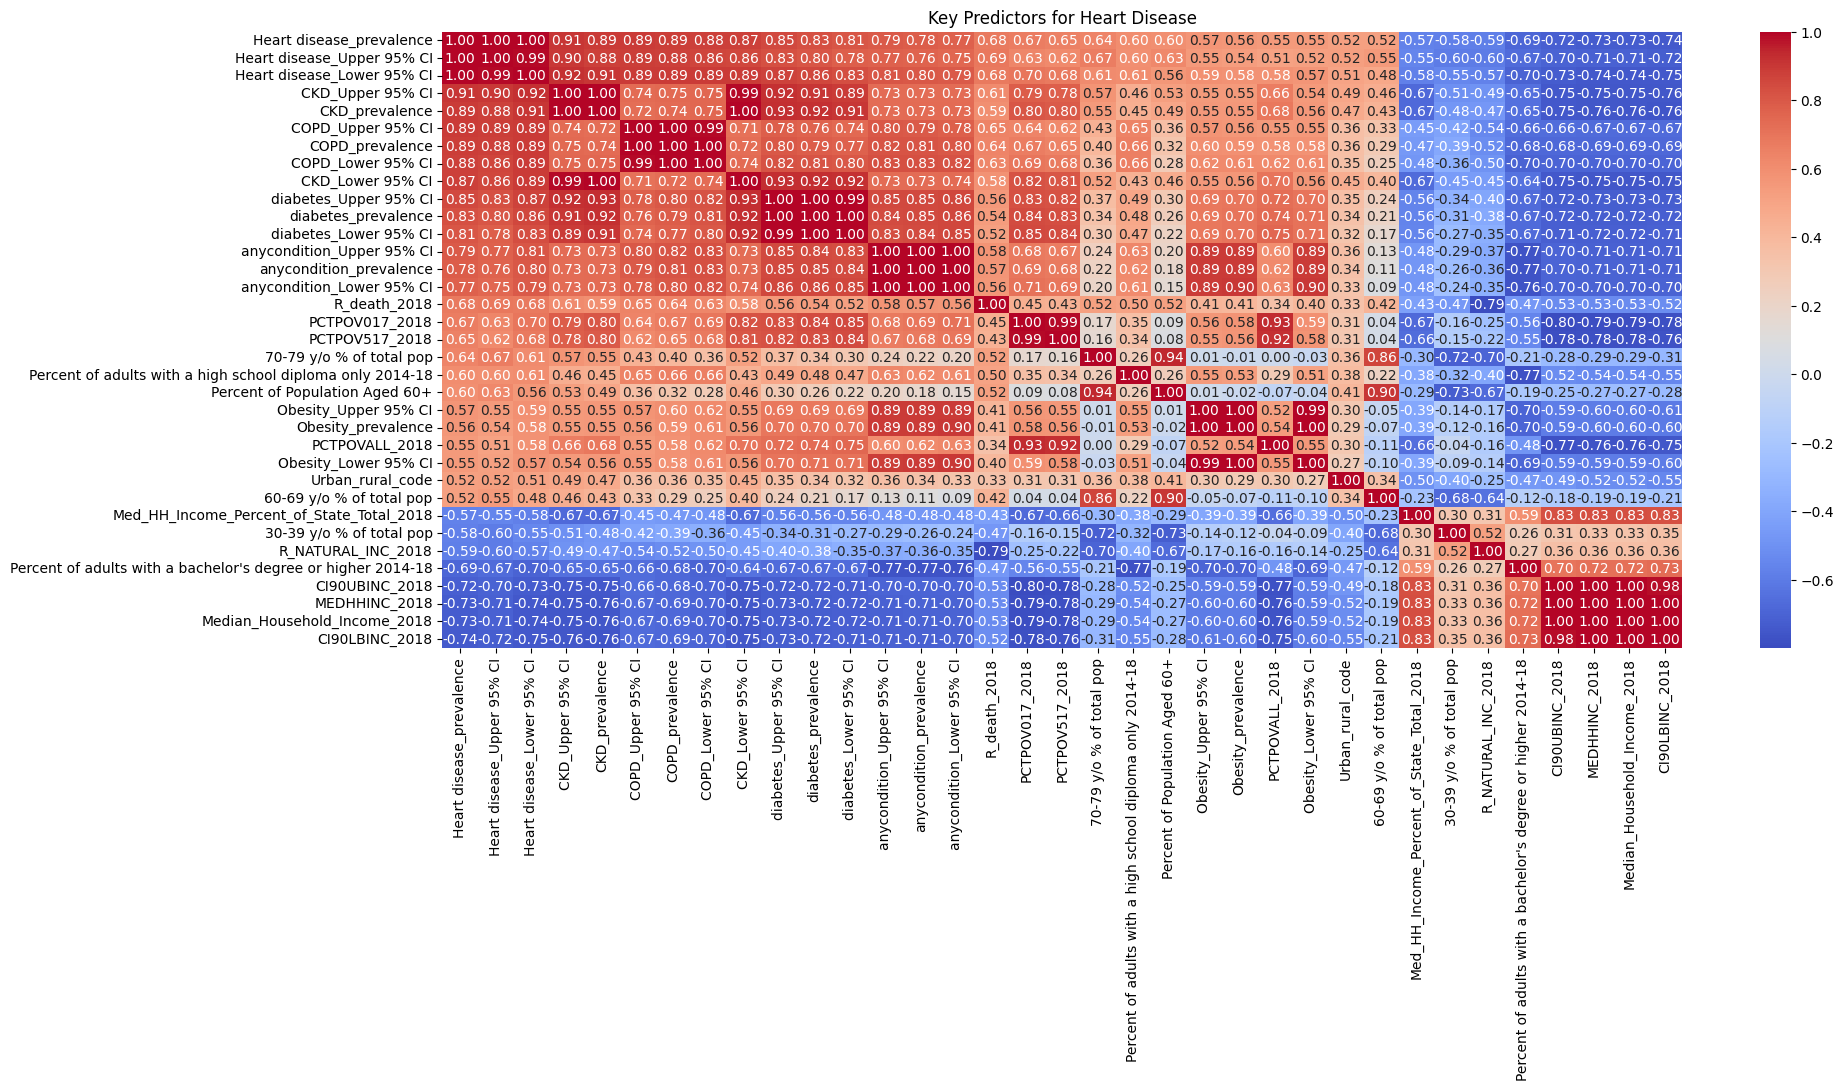

In [13]:
# 1. Filter columns that have at least 0.5 correlation (positive or negative)
important_features = correlations[abs(correlations) > 0.5].index

# 2. Create a smaller correlation matrix
df_small = df_numeric[important_features]
plt.figure(figsize=(20, 8))

# 3. Plot the Heatmap
sns.heatmap(df_small.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Key Predictors for Heart Disease")
plt.show()

In [14]:
# instead of dropping, we will create list of necessary columns.
selected_columns = ['STATE_NAME', 'Heart disease_prevalence', 'CKD_prevalence', 'COPD_prevalence', 'diabetes_prevalence', 'Percent of Population Aged 60+', 'Obesity_prevalence', 'Percent of adults with a bachelor\'s degree or higher 2014-18', 'Med_HH_Income_Percent_of_State_Total_2018', 'Median_Household_Income_2018']
df = df[selected_columns]
print(tabulate(df.head(), headers= "keys", tablefmt= "psql"))

+----+--------------+----------------------------+------------------+-------------------+-----------------------+----------------------------------+----------------------+----------------------------------------------------------------+---------------------------------------------+--------------------------------+
|    | STATE_NAME   |   Heart disease_prevalence |   CKD_prevalence |   COPD_prevalence |   diabetes_prevalence |   Percent of Population Aged 60+ |   Obesity_prevalence |   Percent of adults with a bachelor's degree or higher 2014-18 |   Med_HH_Income_Percent_of_State_Total_2018 |   Median_Household_Income_2018 |
|----+--------------+----------------------------+------------------+-------------------+-----------------------+----------------------------------+----------------------+----------------------------------------------------------------+---------------------------------------------+--------------------------------|
|  0 | Alabama      |                        7.9 |  

### 3.8.1 Conclusion about Columns Selection for Dataset

This heatmap clearly shows that we have many variables that are highly correlated with Heart disease_prevalence (our target), but it also reveals a lot of redundancy.
I will exclude variables with strong Multicollinearity.

1. Drop the (CI) Noise: Notice that variables like Heart disease_Upper 95% CI and Heart disease_Lower 95% CI have a 1.00 correlation with the prevalence.
Reason: These are mathematically derived from the prevalence itself. Using them to predict the target is noise and provides no new information.
    - Action: Drop all columns containing "CI" or "Upper/Lower".
2. Choose the "Best" Health Predictors: CKD_prevalence, COPD_prevalence, and diabetes_prevalence. They all correlate highly (0.80+) with Heart Disease.
    - Action: Keep diabetes_prevalence and COPD_prevalence as they are distinct biological drivers, but we might drop CKD if the model becomes too complex.
3. Socioeconomic Predictors: PCTPOVALL_2018 (Poverty percentage) has a strong positive correlation (0.55). Median_Household_Income_2018 has a strong negative correlation (-0.73).
    - Action: These are necessary. However, since they are opposites, we usually pick the one with the higher absolute correlation. In this case, Median_Household_Income_2018 is the stronger predictor.

# Step 4: Analysis of Univariate Variables
## 4.1 Categorical Variable Analysis

In [15]:
# Select only columns with 'object' data type (strings/categories)
categorical_val = df.select_dtypes(include= ['str']).columns.tolist()
print(f"Categorical Variables: {categorical_val}")

Categorical Variables: ['STATE_NAME']


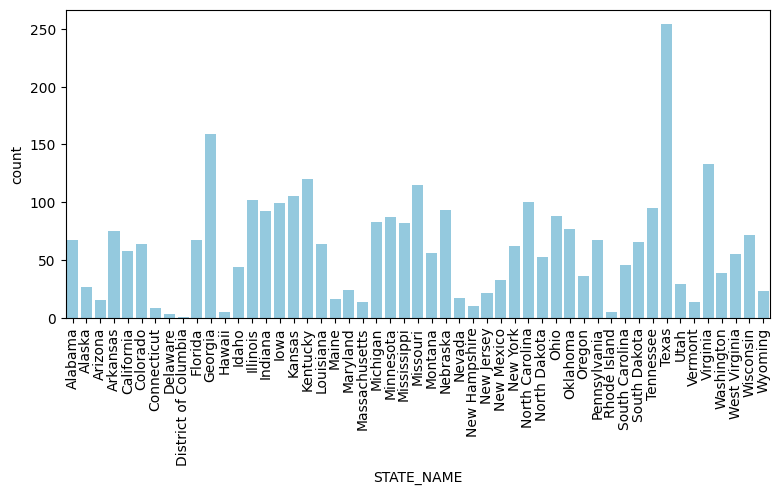

In [16]:
# Creating countplots for the categorical variables
# It is better to use countplot to visualize the behavior 
nrows = 1
ncols = 2
fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize = (20, 4 * nrows))
axes_flat = axes.flatten()

for i, col in enumerate(categorical_val):
    if i < len(axes_flat):
        sns.countplot(data = df, x= col,  ax = axes_flat[i], orient= 'v', color= "skyblue")
        axes_flat[i].tick_params(axis='x', rotation=90)
    if i >= 1:
        axes_flat[i].set(ylabel= None)
    
    # Hide any unused subplots
for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

# plt.tight_layout()
plt.show()

### 4.1.1 Conclusions on Countplot for Categorical Variables
- The TOP 5 population states are: Texas, Georgia, Virginia, Kentucky and Missouri

## 4.2 Numeric Variables Analysis

In [17]:
# Select only columns with 'int or float' data type (numeric
numerics = df.select_dtypes(include= ['number']).columns.tolist()
print(f"Numeric variables: {numerics}")

Numeric variables: ['Heart disease_prevalence', 'CKD_prevalence', 'COPD_prevalence', 'diabetes_prevalence', 'Percent of Population Aged 60+', 'Obesity_prevalence', "Percent of adults with a bachelor's degree or higher 2014-18", 'Med_HH_Income_Percent_of_State_Total_2018', 'Median_Household_Income_2018']


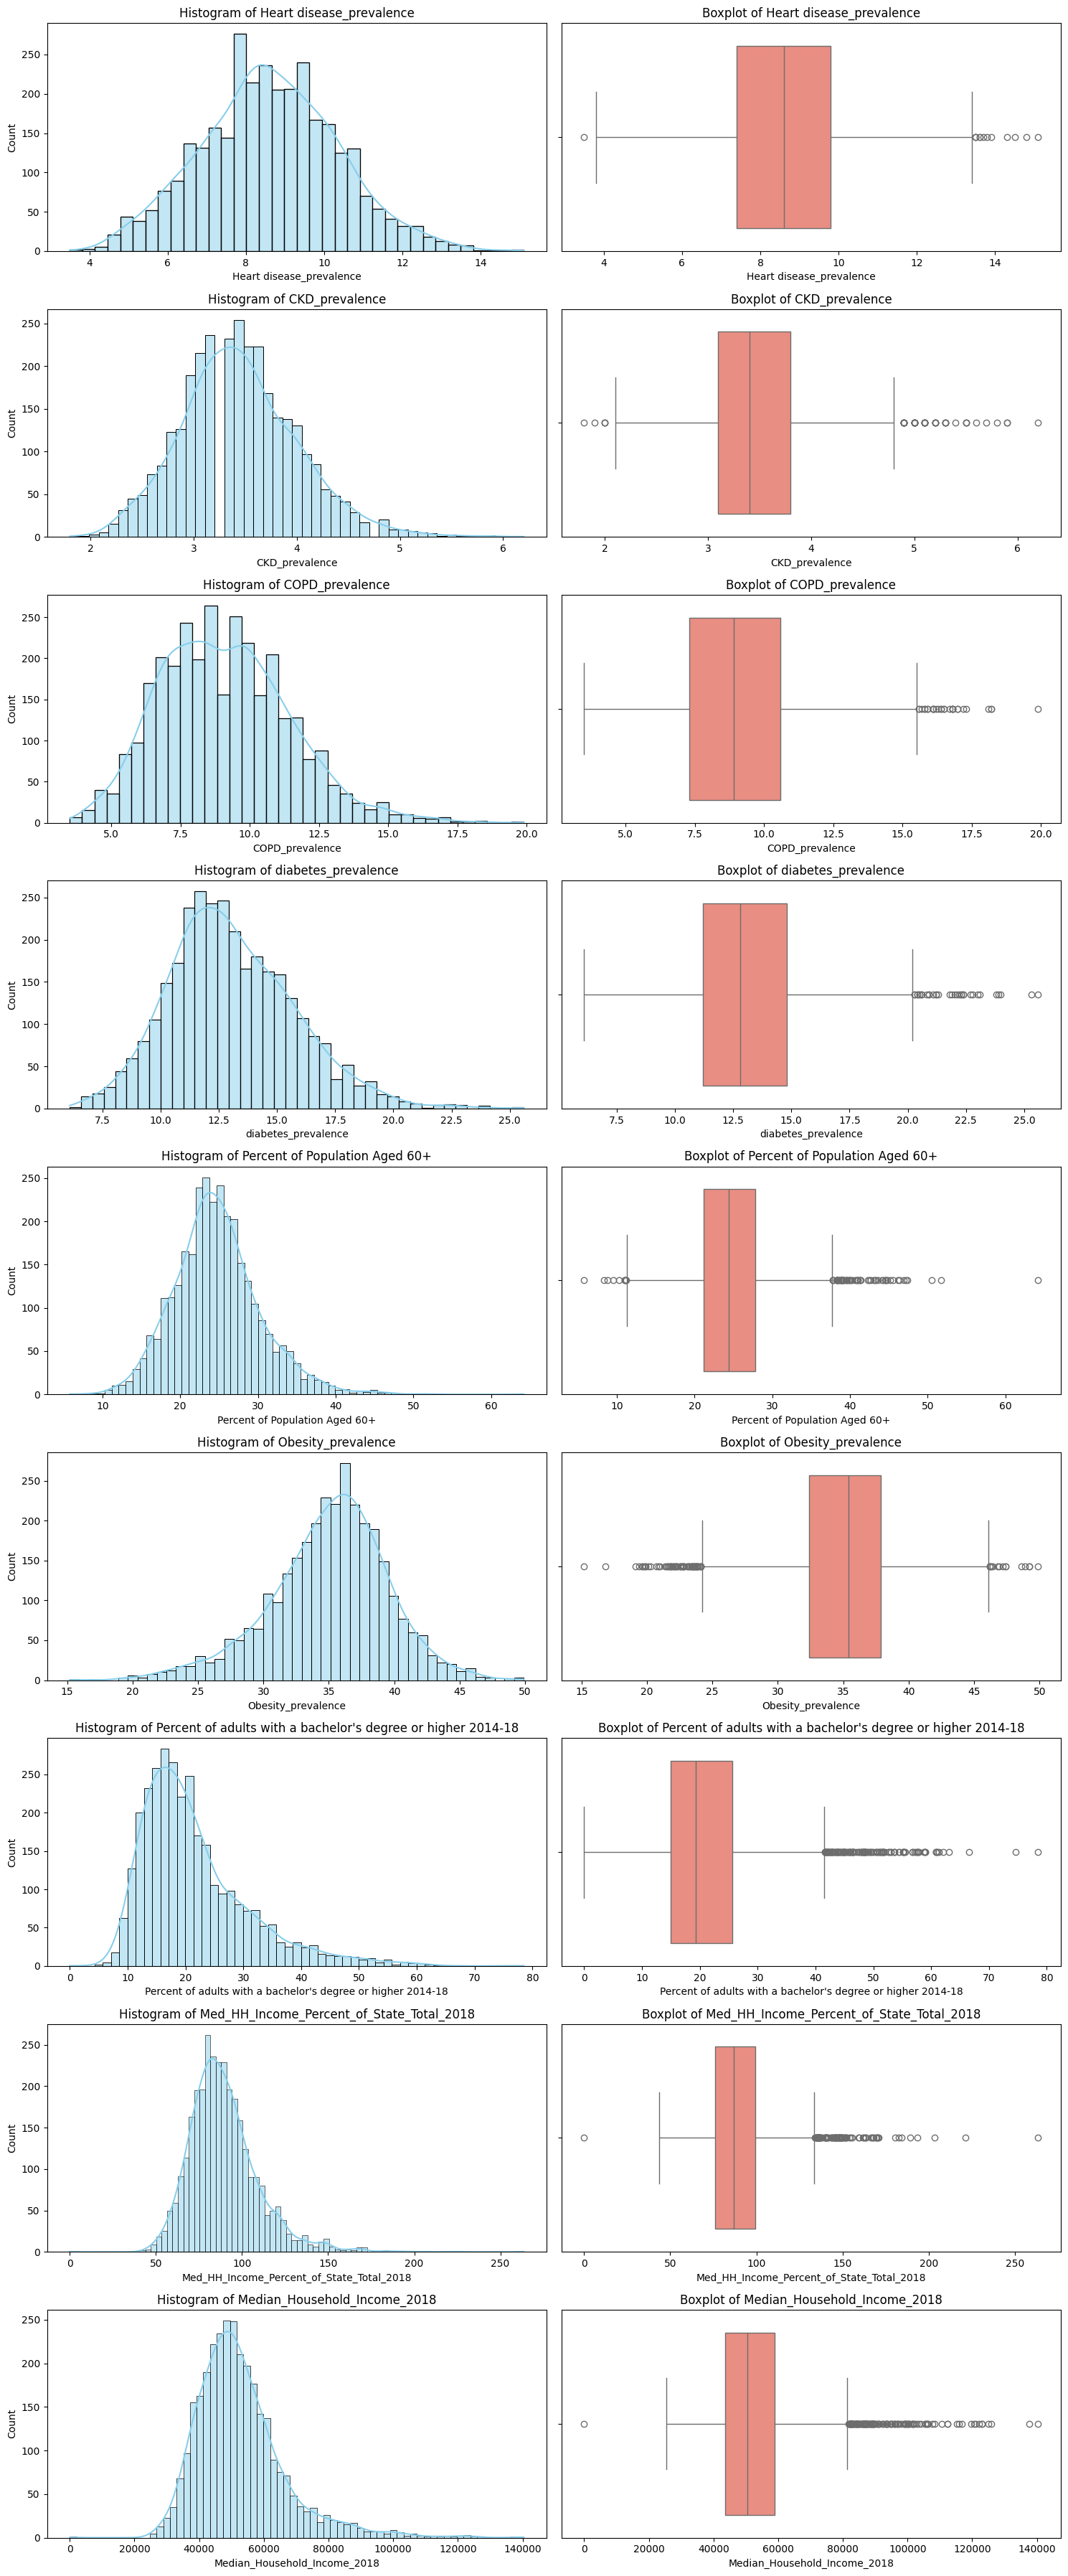

In [18]:
# Creating histplot and boxplot for the numeric variables
nrows = len(numerics)
ncols = 2
fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize=(15, 4 * nrows))

for i, col in enumerate(numerics):
    sns.histplot(df[col], kde=True, ax=axes[i, 0], color="skyblue")
    axes[i, 0].set_title(f'Histogram of {col}')
    sns.boxplot(x=df[col], ax=axes[i, 1], color="salmon")
    axes[i, 1].set_title(f'Boxplot of {col}')

plt.tight_layout()
plt.show()

### 4.2.1 Conclusions for Numerical Variable Charts
1. The Histograms (Left Column): 
    - Normal Distribution: Most of your variables, like Heart disease_prevalence and Obesity_prevalence, follow a "Bell Curve" (Normal Distribution).
    - Skewness: Median_Household_Income_2018 and Bachelor's degree % are right-skewed (they have long tails to the right).
2. The Boxplots (Right Column)
    - Identifying Outliers: The small circles (dots) outside the "whiskers" represent outliers.
    - Impact: Diabetes_prevalence and COPD_prevalence have quite a few high-end outliers.
    - Central Tendency: The vertical line inside the red box is the median. It shows one where the "middle" county sits for each metric.

# Step 5: Multivariate Variables Analysis
## 5.1 Numerical-Numerical Analysis

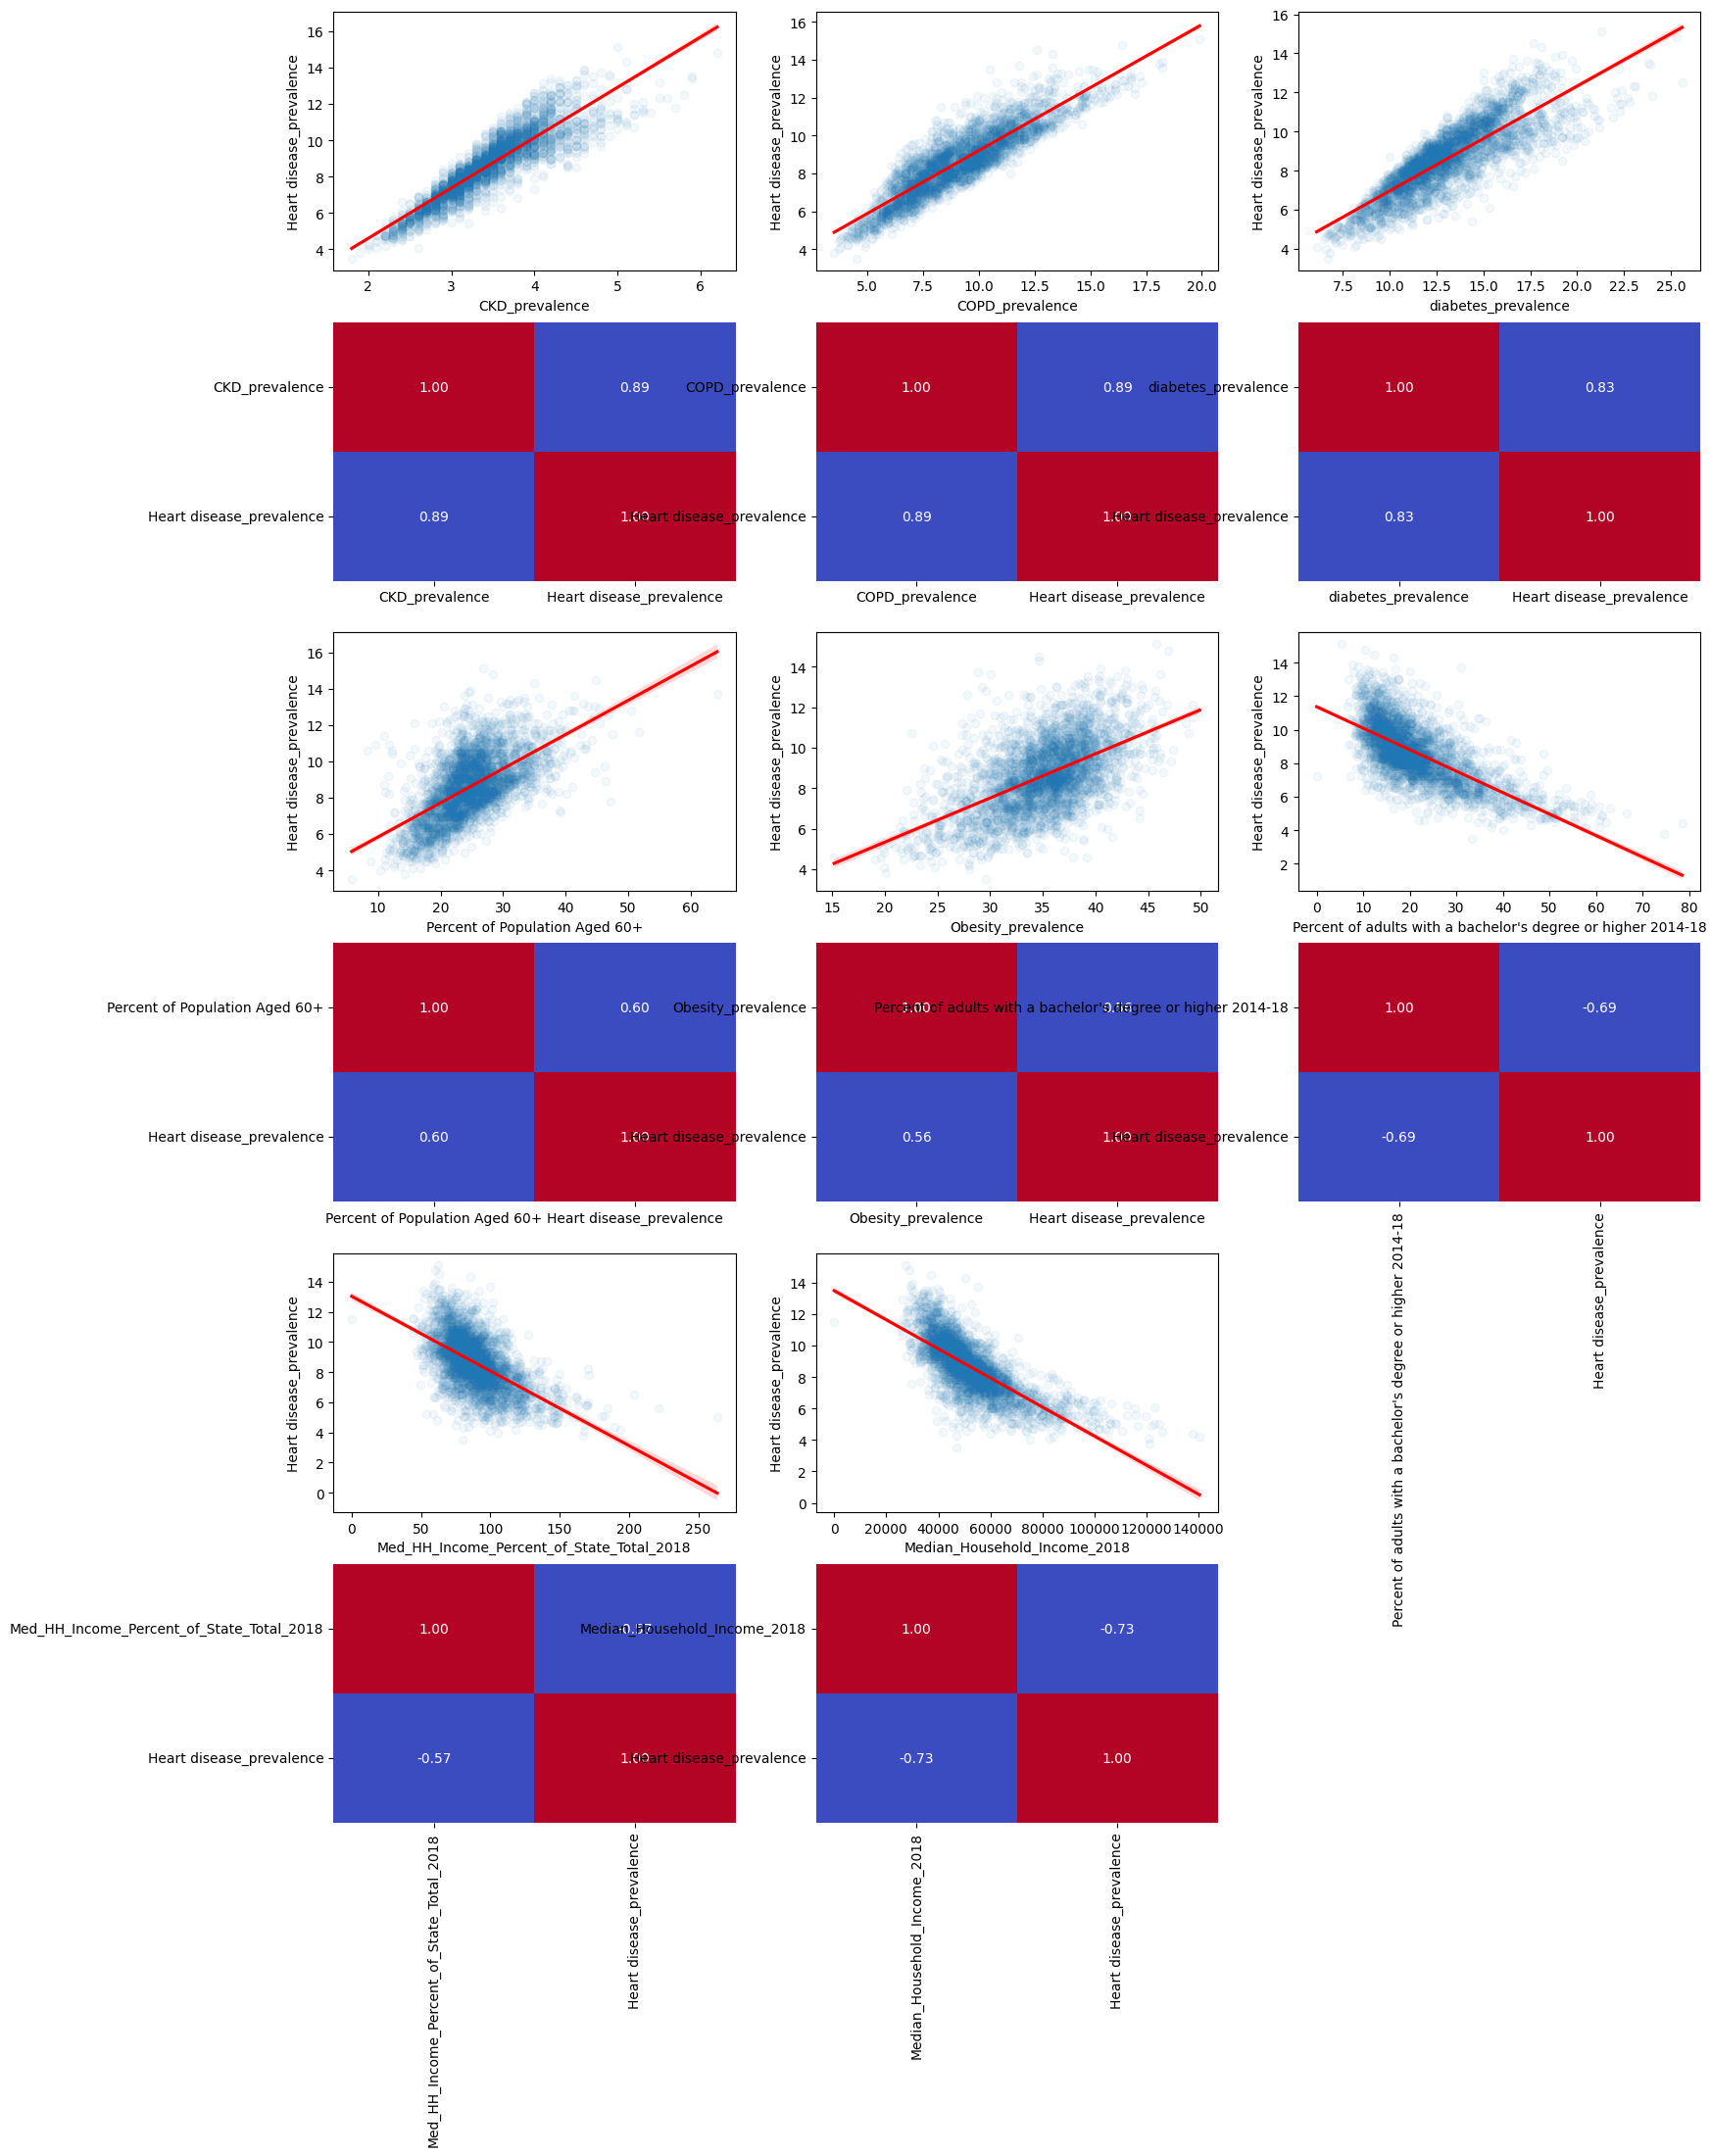

In [19]:
# 1. Excluding the target. The condition is to avoid ploting the target with itself.
if 'Heart disease_prevalence' in numerics: numerics.remove('Heart disease_prevalence')

# 2. Calculate Grid Size
ncols = 3
group_chart = math.ceil(len(numerics) / ncols)
nrows = group_chart * 2 # Double the rows (one for Reg, one for Heatmap)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(18, 4 * nrows))

for chart_idx in range(group_chart):
    # Determine which row we are on for Regplots
    reg_row = chart_idx * 2
    # The Heatmap row is always the one right below it
    heat_row = reg_row + 1

    # Get the 3 variables for this group
    start = chart_idx * ncols
    end = start + ncols
    current_vars = numerics[start:end]

    for col_idx, col in enumerate(current_vars):
        # --- Plot 1: Regplot ---
        sns.regplot(data= df, x= col, y= 'Heart disease_prevalence', ax= axes[reg_row, col_idx], scatter_kws={'alpha':0.05}, line_kws={'color':'red'})
        # axes[reg_row, col_idx].set_title(f'Regplot: {col}')
        # --- Plot 2: Heatmap ---
        sns.heatmap(df[[col, 'Heart disease_prevalence']].corr(), annot=True, fmt=".2f", ax=axes[heat_row, col_idx], cmap='coolwarm', cbar= False)
        # axes[heat_row, col_idx].set_title(f'Corr: {col}')
# 4. Hide empty slots (if any)
for col_idx in range(len(current_vars), ncols):
    axes[reg_row, col_idx].set_visible(False)
    axes[heat_row, col_idx].set_visible(False)


# plt.tight_layout(pad=3.0)
plt.show()

### 5.1.1 Conclusion Num-Num analysis
1. Strong Positive Predictors (Health Drivers)
    - CKD, COPD, and Diabetes: These three show the tightest clusters around the red regression line.
    - Insight: The high correlation coefficients (e.g., 0.89 for CKD and COPD, 0.83 for Diabetes) prove these are the most powerful predictors.
2. Strong Negative Predictors (Socioeconomic Drivers)
    - Income and Education: Notice the regression lines for Median_Household_Income and Bachelor's degree % slope downward.
    - Insight: These have strong negative correlations (-0.73 and -0.69 respectively). This tells the model that higher wealth and education levels are statistically associated with lower heart disease prevalence.
3. Linear Relationship Validation
    - The Red Line: Because the data points (blue dots) follow the straight red lines fairly closely without curving significantly, one have visual confirmation that Linear Regression is the correct tool for this dataset.
    - Variance: Factors like Obesity_prevalence (0.56) and Age 60+ (0.60) show fuzzier clusters, meaning they are important but have more "noise" or variation than the direct health markers.

## 5.2 Num - Num Analysis (other predictors)

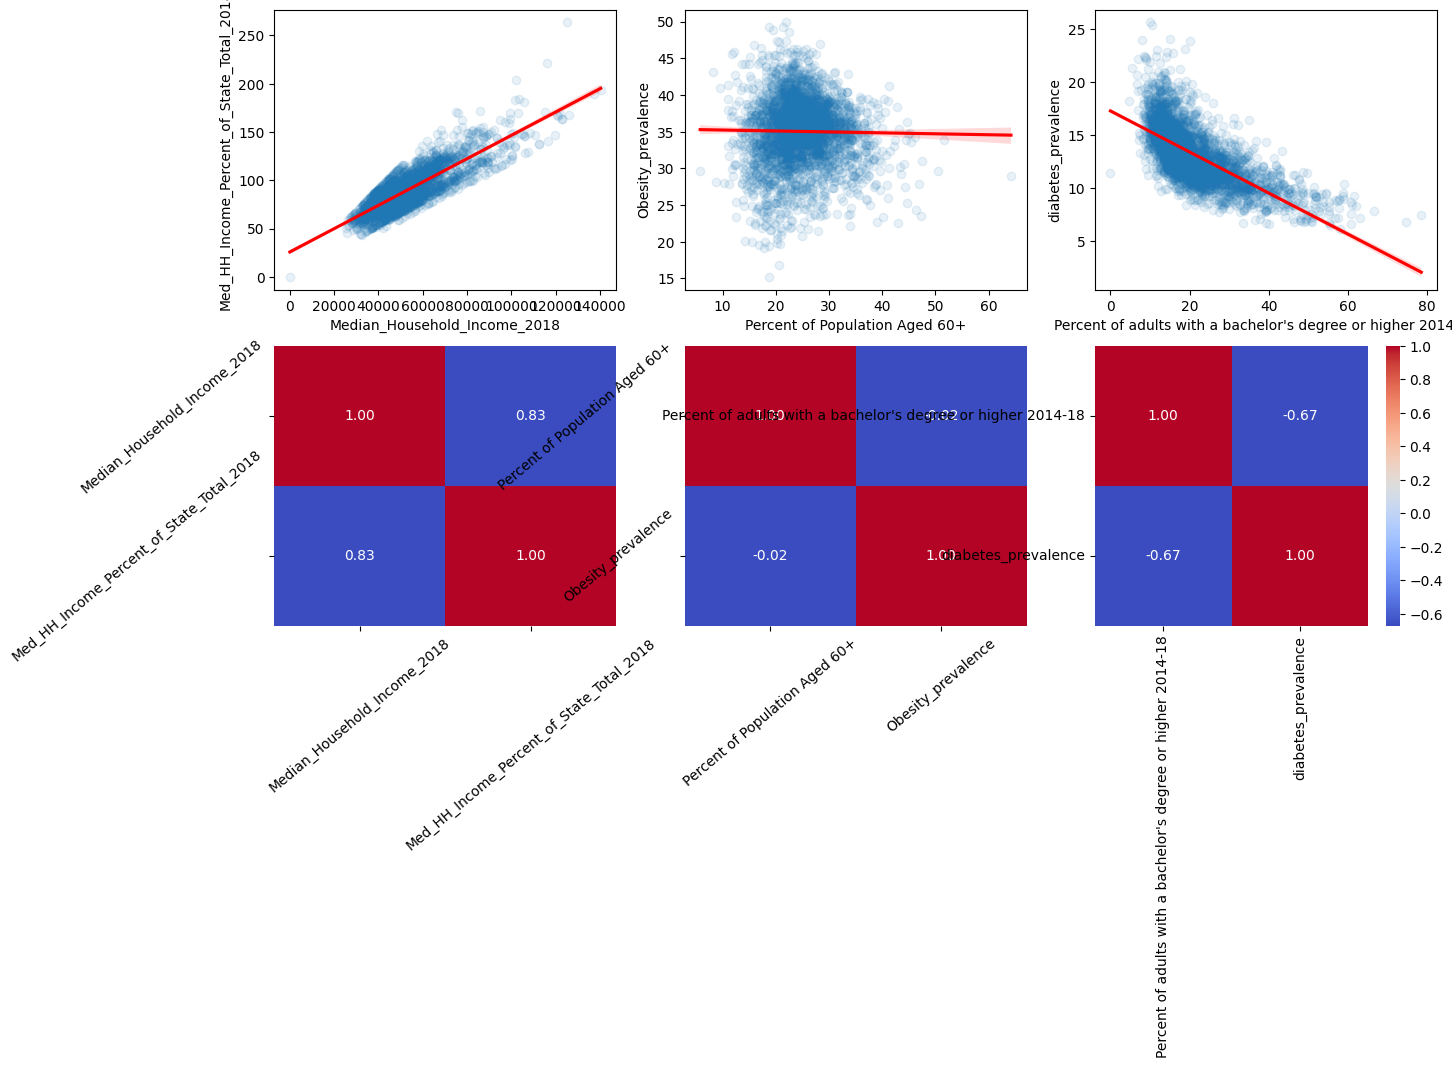

In [20]:
# A quick checking for Multicollinearity between two specific predictors
nrows = 2
ncols = 3
fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize=(5 * ncols, 4 * nrows))

sns.regplot(data=df, ax=axes[0, 0], x='Median_Household_Income_2018', y='Med_HH_Income_Percent_of_State_Total_2018', scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
sns.heatmap(df[['Median_Household_Income_2018', 'Med_HH_Income_Percent_of_State_Total_2018']].corr(), annot=True, fmt=".2f", ax=axes[1, 0], cbar=False, cmap='coolwarm')
axes[1,0].tick_params(rotation= 40)

sns.regplot(data=df, ax=axes[0, 1], x='Percent of Population Aged 60+', y='Obesity_prevalence', scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
sns.heatmap(df[['Percent of Population Aged 60+', 'Obesity_prevalence']].corr(), annot=True, fmt=".2f", ax=axes[1, 1], cbar=False, cmap='coolwarm')
axes[1,1].tick_params(rotation= 40)

sns.regplot(data=df, ax=axes[0, 2], x='Percent of adults with a bachelor\'s degree or higher 2014-18', y='diabetes_prevalence', scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
sns.heatmap(df[['Percent of adults with a bachelor\'s degree or higher 2014-18', 'diabetes_prevalence']].corr(), annot=True, fmt=".2f", ax=axes[1, 2], cmap='coolwarm')
# axes[1,2].tick_params(rotation= 25)

# plt.tight_layout()
plt.show()

### 5.2.1 Conclusion Num-Num (others predictors)
- Strong Linear Alignment: The relationship between Median_Household_Income_2018 and the state percentage is almost perfectly linear (0.83 correlation). This confirms that these two variables are redundant. I will drop the "Med_HH_Income_Percent_of_State_Total_2018" and just keep the raw income.
- Negative Correlation: The chart for Bachelor's degree vs Diabetes shows a clear downward trend (-0.67). This is a great insight for the conclusion: higher education levels are a strong negative predictor of health issues.
- The "Flat" Line: Notice the Obesity_prevalence vs Age 60+ chart has a very flat red line (-0.02 correlation). This means age and obesity aren't directly linked in this specific way.

## 5.3 Categorical-Categorical Analysis

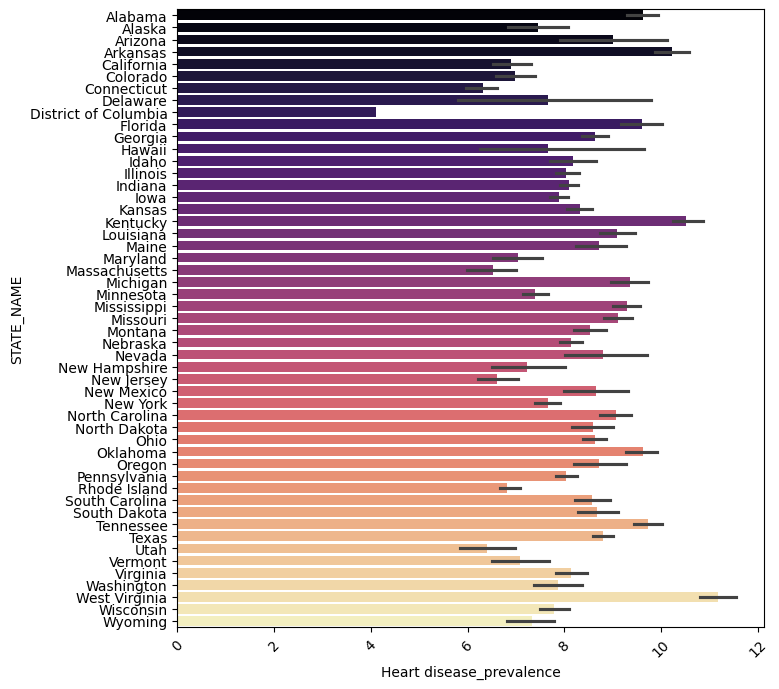

In [21]:
# Categorical Variables: ['STATE_NAME']
if 'Heart disease_prevalence' in categorical_val: categorical_val.remove('Heart disease_prevalence')
ncols = 3
nrows = math.ceil(len(categorical_val) / ncols)
fig, axes = plt.subplots(nrows= nrows, ncols= ncols , figsize = (20, 7 * nrows))
axes_flat = axes.flatten()

for i, col in enumerate(categorical_val):
    sns.barplot(ax = axes_flat[i], data = df, x = 'Heart disease_prevalence', y= col, hue= col, palette='magma') # NOTE: in this project "X" and "Y" were inverted for better chart visibility
    axes_flat[i].tick_params(axis= 'x', rotation= 45)

for j in range(i + 1, len(axes_flat)):
    axes_flat[j].set_visible(False)

plt.tight_layout()
plt.show()

### 5.3.1 Conclusion Cat - Cat Analysis
- Geographic Variation: The chart highlights significant disparities in Heart disease_prevalence across the US. For example, West Virginia and Kentucky show some of the highest average prevalence rates, while the District of Columbia and Colorado are among the lowest.
- Confidence Intervals (Black Lines): The small black horizontal lines at the end of each bar represent the error bars or confidence intervals.
- Ranking Insight: By sorting the bars by color/prevalence, one can easily see which states might need more focus in a health policy model.
- Model Justification: While the averages differ by state, many bars have overlapping error bars.

## 5.4 Combinations with Others Predictors
- No need to do the combination as we only have one categorical variable chosen for the analysis.

## 5.5 Correlation / Factorize Analysis
In order to seize all variable in a heatmap plot analysis, I will factorize categorical variables and save them in a json.
Categorical variables: ['sex', 'smoker', 'region']

In [22]:
categorical_vars = ['STATE_NAME']
categorical_num = [var + '_num' for var in categorical_vars]
# Categorical factorization
for col in categorical_num:
    no_num_col = col[:-4]
    df[str(col)] = pd.factorize(df[no_num_col])[0]
# Visibility of the last loop to see factorization
print(tabulate(df[[no_num_col, col]].head(), headers='keys', tablefmt='psql'))

+----+--------------+------------------+
|    | STATE_NAME   |   STATE_NAME_num |
|----+--------------+------------------|
|  0 | Alabama      |                0 |
|  1 | Alabama      |                0 |
|  2 | Alabama      |                0 |
|  3 | Alabama      |                0 |
|  4 | Alabama      |                0 |
+----+--------------+------------------+


## 5.6 Saving the JSON

In [23]:
# Save the json
prefix_name = '_transformation_rules'
for col in categorical_num:
    no_num_col = col[:-4]
    file_name = no_num_col + prefix_name + ".json"
    factorized_dict = {row[no_num_col]: row[col] for index, row in df[[col, no_num_col]].drop_duplicates().iterrows()}
    with open("../data/interim/" + file_name, "w") as f:
        json.dump(factorized_dict, f)

## 5.7 Num - Cat Analysis (Complete)

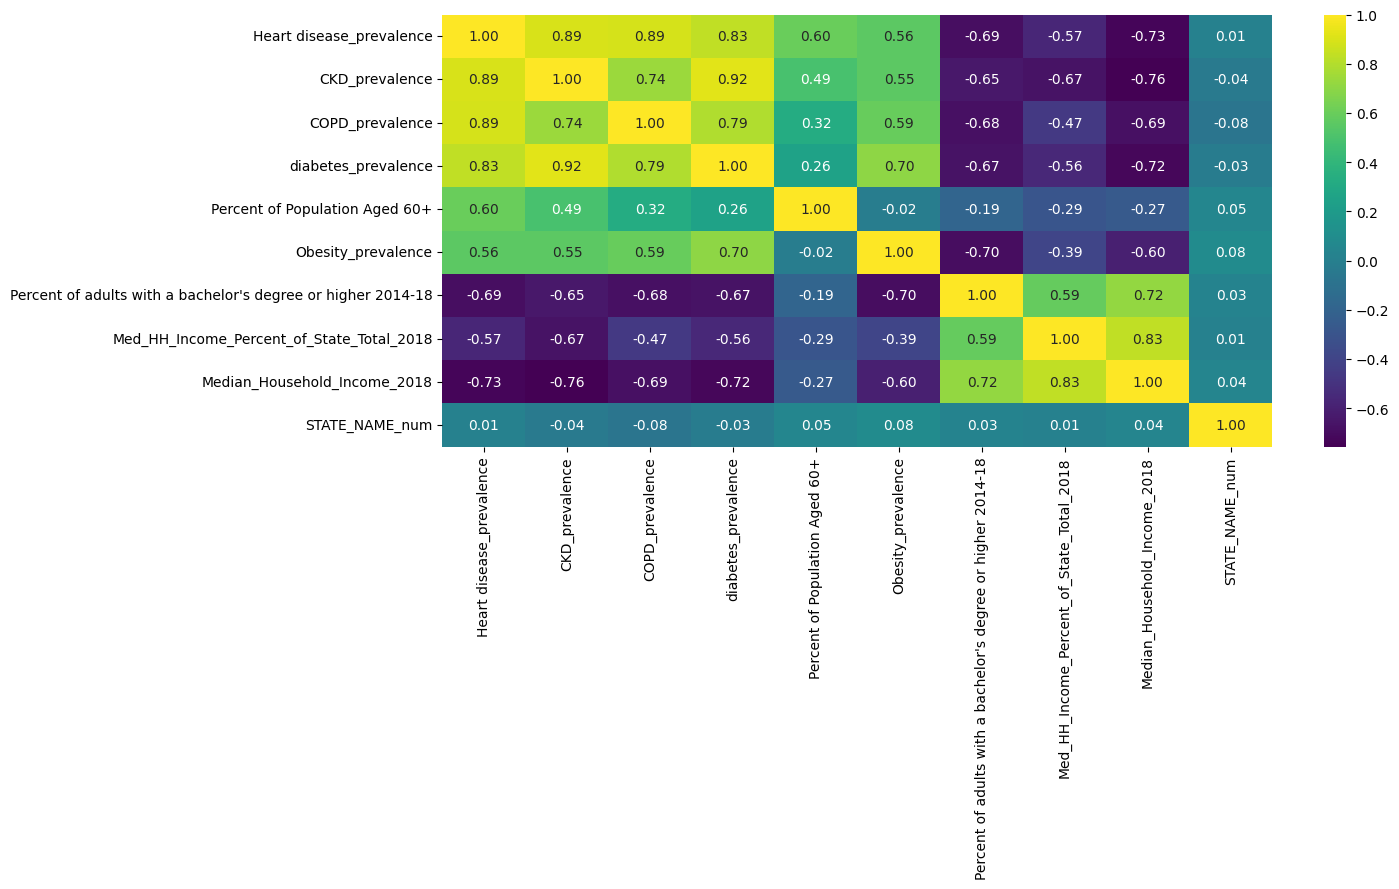

In [24]:
# Creating heatmap chart to analyze complete variables correlation
cols_num = df.select_dtypes(include= ['number']).columns.tolist()
fig, ax = plt.subplots(figsize= (15, 9))
sns.heatmap(df[cols_num].corr(method= "pearson"), annot= True, fmt= ".2f", cmap= "viridis", ax= ax).tick_params(axis= 'x', rotation= 90)
plt.tight_layout()
plt.show()

### 5.7.1 Conclusion Correlation Heatmap

- **The Irrelevance**: Notice the STATE_NAME_num row at the bottom. Its correlation with Heart Disease is only 0.01. This confirms that simply giving a state a number doesn't help the model; the actual predictors are the health and economic conditions within those states.
- **The Multicollinearity**: It has extremely high correlations (0.70 to 0.92) between CKD, COPD, and diabetes. While they all predict heart disease well, keeping all three might be redundant.
- **Income Redundancy**: Median_Household_Income_2018 and Med_HH_Income_Percent_of_State_Total_2018 have a 0.83 correlation with each other.
* **Decision**: I should drop the "Percent of State Total" and keep the raw Median Income, as it has a stronger individual correlation with the target (-0.73 vs -0.57).
* **Strongest Driver**: CKD_prevalence and COPD_prevalence remain the strongest positive predictors (0.89), while Median_Household_Income is the strongest negative predictor (-0.73).

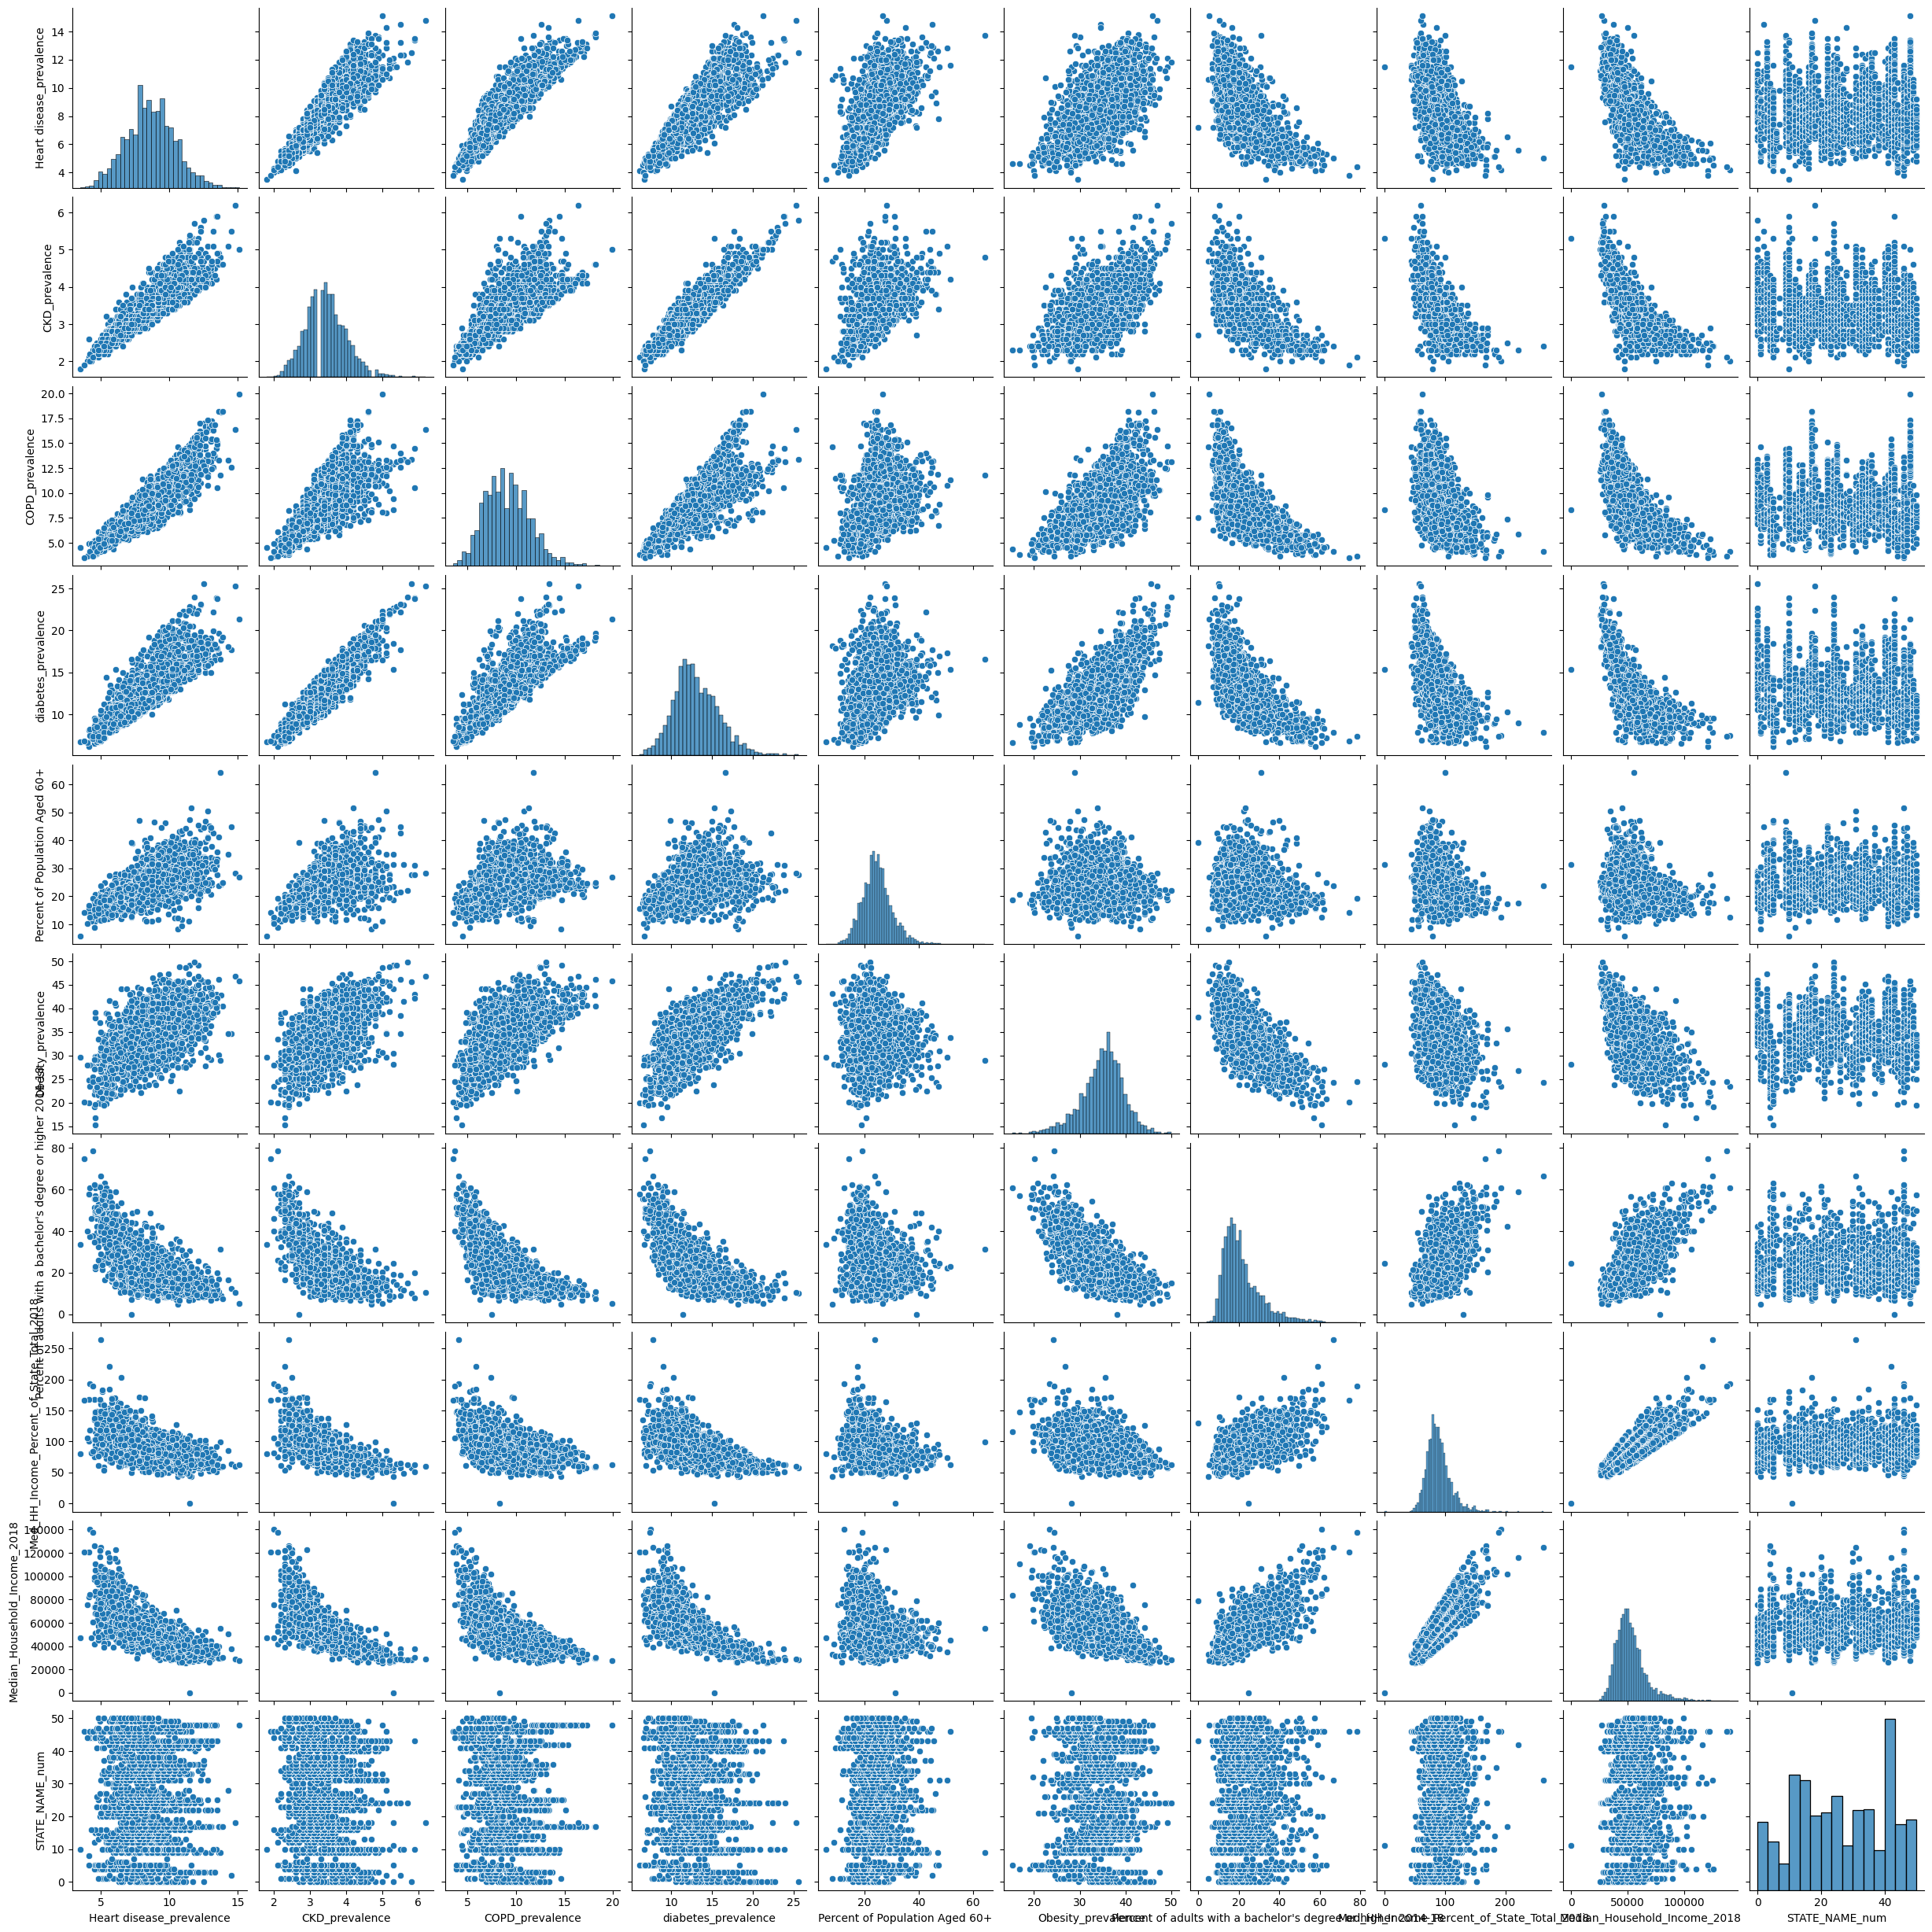

In [25]:
# Creating pairplot to have a variables behaviour visibility 
sns.pairplot(data= df)

## 5.8 Final DataSet Columns
FINAL_COLS = ['Heart disease_prevalence', 'CKD_prevalence', 'COPD_prevalence', 'Percent of Population Aged 60+', 'Obesity_prevalence', 'Percent of adults with a bachelor\'s degree or higher 2014-18', 'Median_Household_Income_2018']					


In [26]:
final_cols = ['Heart disease_prevalence', 'CKD_prevalence', 'COPD_prevalence', 'Percent of Population Aged 60+', 'Obesity_prevalence', 'Percent of adults with a bachelor\'s degree or higher 2014-18', 'Median_Household_Income_2018']
df = df[final_cols]

In [27]:
print(tabulate(df.describe(), headers= "keys", tablefmt= "psql"))

+-------+----------------------------+------------------+-------------------+----------------------------------+----------------------+----------------------------------------------------------------+--------------------------------+
|       |   Heart disease_prevalence |   CKD_prevalence |   COPD_prevalence |   Percent of Population Aged 60+ |   Obesity_prevalence |   Percent of adults with a bachelor's degree or higher 2014-18 |   Median_Household_Income_2018 |
|-------+----------------------------+------------------+-------------------+----------------------------------+----------------------+----------------------------------------------------------------+--------------------------------|
| count |                 3140       |      3140        |        3140       |                       3140       |           3140       |                                                     3140       |                         3140   |
| mean  |                    8.6078  |         3.44624  |       

# Step 6: Feature Engineering
## 6.1 Outlier analysis

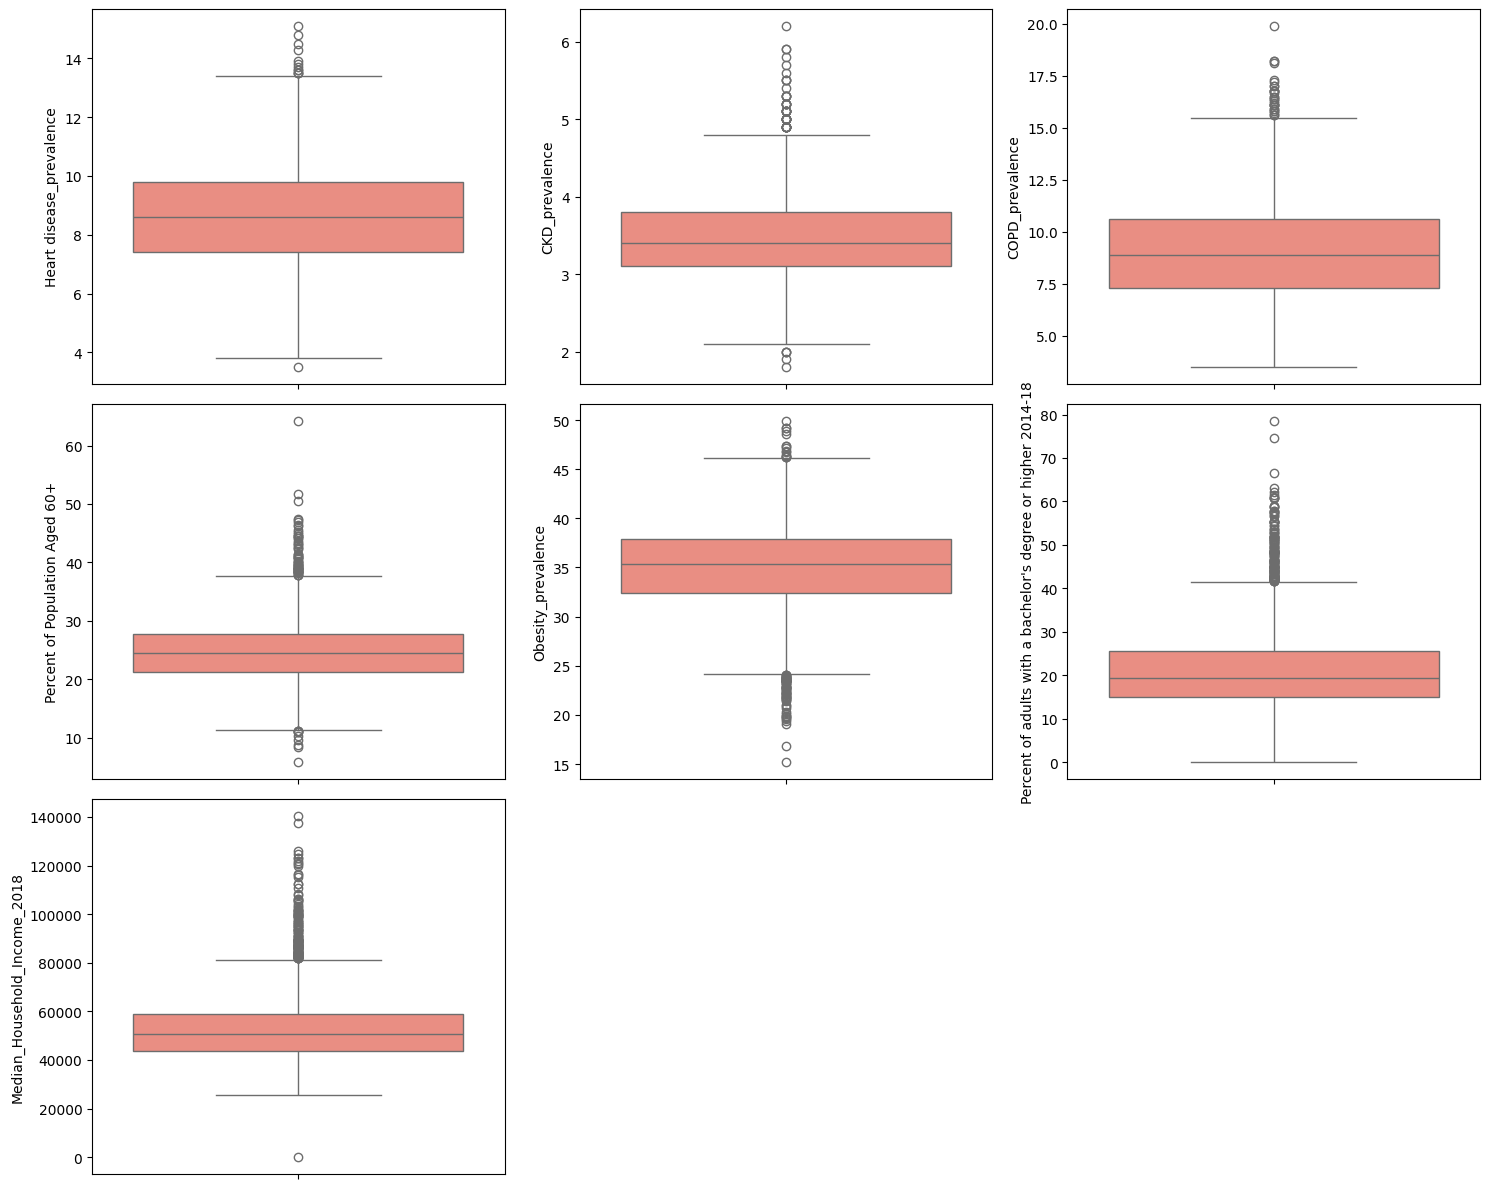

In [28]:
# Creating boxplot to understand the outliers in each variable
ncols = 3
nrows = math.ceil(len(final_cols) / ncols)
fig, axes = plt.subplots(nrows= nrows, ncols= ncols, figsize= (15, 4 * nrows))

axes = axes.flatten()
for i, col in enumerate(final_cols):
    sns.boxplot(data= df, y= col, ax= axes[i], color= 'salmon')
for j in range(len(final_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### 6.1.1 Conclusion Boxplots Charts
- **Heart disease_prevalence** is very well-balanced. The median is roughly in the center of the box, which is ideal for Linear Regression.
- **CKD_prevalence and COPD_prevalence** have several high outliers, likely representing specific counties with severe health crises.
- **Median_Household_Income_2018 and Percent of adults with a bachelor's degree** have the most significant outliers.
- **Obesity_prevalence and Percent of Population Aged 60+** have relatively "tight" boxes.
- **Median_Household_Income_2018** has a massive scale (from 20k to over 140k).

In [34]:
# Necessary coding to replace outliers creating upper and lower limits
# SAVING ALL DATASETS.

df_WITH_outliers = df.copy()
df_WITHOUT_outliers = df.copy() # This need to be modified. For every variable with outliers, I will replce outliers values.

outliers_cols = ['CKD_prevalence', 'COPD_prevalence', 'Percent of Population Aged 60+', 'Obesity_prevalence', 'Percent of adults with a bachelor\'s degree or higher 2014-18', 'Median_Household_Income_2018'] # The target variable price can't be modified so we leave as it is.

def replace_outliers(column, data_df):
   col_stats = df[column].describe()
   col_iqr = col_stats["75%"] - col_stats["25%"]
   upper_limit = round(float(col_stats["75%"] + 1.5 * col_iqr), 2)
   lower_limit = round(float(col_stats["25%"] - 1.5 * col_iqr), 2)

   if lower_limit < 0: lower_limit = min(df[column])
   # Let's take out upper outliers 
   data_df[column] = data_df[column].apply(lambda x: x if (x <= upper_limit) else upper_limit)
   # Let's take out lower outliers 
   data_df[column] = data_df[column].apply(lambda x: x if (x >= lower_limit) else lower_limit)
   return data_df.copy(), [lower_limit, upper_limit]

outliers_dict = {}
for column in outliers_cols:
   df_WITHOUT_outliers, limits = replace_outliers(column, df_WITHOUT_outliers)
   outliers_dict.update({column: limits})

outliers_dict # This jason needs to be saved

{'CKD_prevalence': [2.05, 4.85],
 'COPD_prevalence': [2.35, 15.55],
 'Percent of Population Aged 60+': [11.3, 37.7],
 'Obesity_prevalence': [24.15, 46.15],
 "Percent of adults with a bachelor's degree or higher 2014-18": [0.0, 41.5],
 'Median_Household_Income_2018': [20959.12, 81540.12]}

In [35]:
# Saving the json dictionary for outliers limit
with open('../data/interim/outliers_dict.json', 'w') as f:
     json.dump(outliers_dict, f)

## 6.2 Missing Value Analysis

In [36]:
print("The list below, will show if dataset WITH outliers has any null value for the variables:")
print(df_WITH_outliers.isnull().sum().sort_values(ascending= False))

The list below, will show if dataset WITH outliers has any null value for the variables:
Heart disease_prevalence                                        0
CKD_prevalence                                                  0
COPD_prevalence                                                 0
Percent of Population Aged 60+                                  0
Obesity_prevalence                                              0
Percent of adults with a bachelor's degree or higher 2014-18    0
Median_Household_Income_2018                                    0
dtype: int64


In [37]:
print("The list below, will show if dataset WITHOUT outliers has any null value for the variables:")
print(df_WITHOUT_outliers.isnull().sum().sort_values(ascending= False))

The list below, will show if dataset WITHOUT outliers has any null value for the variables:
Heart disease_prevalence                                        0
CKD_prevalence                                                  0
COPD_prevalence                                                 0
Percent of Population Aged 60+                                  0
Obesity_prevalence                                              0
Percent of adults with a bachelor's degree or higher 2014-18    0
Median_Household_Income_2018                                    0
dtype: int64


## 6.3 Inference of New Features
* The have CKD_prevalence (Kidney Disease) and COPD_prevalence (Lung Disease).
    - These two have a very high correlation (0.89). Instead of the model trying to figure out which one is more important, one can create a feature that represents the total "disease load" of a county.
    - The Math: Chronic_Disease_Load = (CKD_prevalence + COPD_prevalence) / 2
    - The purpose: Creating this average reduces Multicollinearity, which makes the Linear Regression coefficients more stable and reliable.


In [38]:
# (CKD_prevalence + COPD_prevalence) / 2: Captures the total "disease load" of a county.
df_WITH_outliers['Chronic_Disease_Load'] = (df_WITH_outliers['CKD_prevalence'] + df_WITH_outliers['COPD_prevalence']) / 2 # calculate the AVERAGE.
df_WITHOUT_outliers['Chronic_Disease_Load'] = (df_WITHOUT_outliers['CKD_prevalence'] + df_WITHOUT_outliers['COPD_prevalence']) / 2

In [39]:
print("Table with new columns added.\nWITH outliers:")
print(tabulate(df_WITH_outliers.head(), headers= "keys", tablefmt= "psql"))

Table with new columns added.
WITH outliers:
+----+----------------------------+------------------+-------------------+----------------------------------+----------------------+----------------------------------------------------------------+--------------------------------+------------------------+
|    |   Heart disease_prevalence |   CKD_prevalence |   COPD_prevalence |   Percent of Population Aged 60+ |   Obesity_prevalence |   Percent of adults with a bachelor's degree or higher 2014-18 |   Median_Household_Income_2018 |   Chronic_Disease_Load |
|----+----------------------------+------------------+-------------------+----------------------------------+----------------------+----------------------------------------------------------------+--------------------------------+------------------------|
|  0 |                        7.9 |              3.1 |               8.6 |                             19.1 |                 35.8 |                                                       

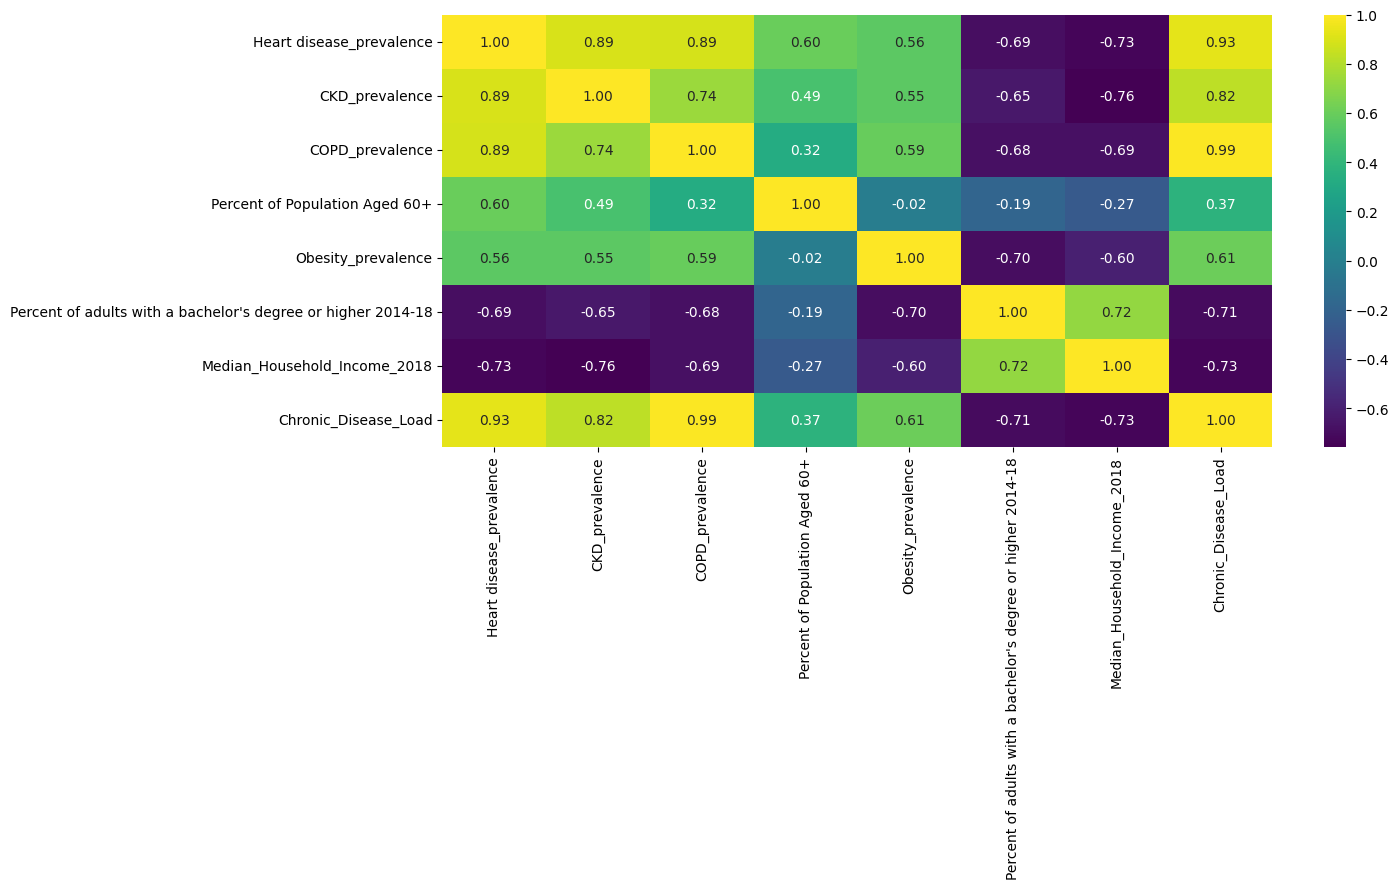

In [44]:
# Creating << NEW >> heatmap chart to analyze complete variables correlation
cols_num = df_WITH_outliers.select_dtypes(include=['number']).columns.tolist()
fig, ax = plt.subplots(figsize= (15, 9))
sns.heatmap(df_WITH_outliers[cols_num].corr(method="pearson"), annot=True, fmt=".2f", cmap="viridis", ax= ax).tick_params(axis= 'x', rotation= 90)
plt.tight_layout()
plt.show()

### 6.3.1 Conclusion on New Features
- **The Super-Predictor**: The engineered variable, Chronic_Disease_Load, has a massive 0.93 correlation with Heart disease_prevalence. This is even higher than the individual correlations for CKD (0.89) or COPD (0.89) alone.
- **Solving Multicollinearity**: Previously, CKD and COPD were highly redundant with each other (0.74 correlation). By merging them, there is a more robust metric.
-**Strong Socioeconomic Links**: The Chronic_Disease_Load also shows strong relationships with your demographic features, such as a -0.71 correlation with Bachelor's degree % and a -0.73 correlation with Median_Household_Income_2018.

* **Given the conclusion above**, replace the individual CKD and COPD columns with this one engineered feature.
    - **FINAL_COL_DATSET** = ['Heart disease_prevalence', 'Percent of Population Aged 60+', 'Obesity_prevalence', 'Percent of adults with a bachelor\'s degree or higher 2014-18', 'Median_Household_Income_2018', 'Chronic_Disease_Load']


In [45]:
FINAL_COL_DATSET = ['Heart disease_prevalence', 'Percent of Population Aged 60+', 'Obesity_prevalence', 'Percent of adults with a bachelor\'s degree or higher 2014-18', 'Median_Household_Income_2018', 'Chronic_Disease_Load']
df_WITH_outliers = df_WITH_outliers[FINAL_COL_DATSET]

In [46]:
df_WITH_outliers.head()

Heart disease_prevalence  Percent of Population Aged 60+  \
0                       7.9                            19.1   
1                       7.8                            26.3   
2                      11.0                            23.5   
3                       8.6                            21.1   
4                       9.2                            23.6   

   Obesity_prevalence  \
0                35.8   
1                29.7   
2                40.7   
3                38.7   
4                34.0   

   Percent of adults with a bachelor's degree or higher 2014-18  \
0                                               27.7              
1                                               31.3              
2                                               12.2              
3                                               11.5              
4                                               12.6              

   Median_Household_Income_2018  Chronic_Disease_Load  
0                         59338                  5.85  
1                         57588                  5.90  
2                         34382                  8.30  
3                         46064                  6.65  
4                         50412                  6.95

## 6.4 Feature Scaling

In [47]:
# Divide the set into train and test

# df_WITH_outliers 
# df_WITHOUT_outliers 
				
predictors = ['Percent of Population Aged 60+', 'Obesity_prevalence', 'Percent of adults with a bachelor\'s degree or higher 2014-18', 'Median_Household_Income_2018', 'Chronic_Disease_Load']
target = 'Heart disease_prevalence'

X_WITH_outliers = df_WITH_outliers.drop(target, axis = 1)[predictors]
X_WITHOUT_outliers = df_WITHOUT_outliers.drop(target, axis = 1)[predictors]
y = df_WITH_outliers[target]

X_train_WITH_outliers, X_test_WITH_outliers, y_train, y_test = train_test_split(X_WITH_outliers, y, test_size = 0.2, random_state = 10)
X_train_WITHOUT_outliers, X_test_WITHOUT_outliers = train_test_split(X_WITHOUT_outliers, test_size = 0.2, random_state = 10)

In [48]:
# Normalization and MIN_MAX Scaling

# X_train_WITH_outliers
# X_train_WITHOUT_outliers

# X_test_WITH_outliers
# X_test_WITHOUT_outliers

# WE NEED TO SAVE 3 OCCURRENCE: 1) DATASET PLANE (WITH NO CHANGES), 2) DATASET NORMALIZED, 3) DATASET MIN-MAX

## NORMALIZATION
### WITH OUTLIERS
norm_WITH_outliers = StandardScaler() # StandardScaler(), used to "normalize" or "resize" your data so that all your features are on the same scale. 
# .fit(), The "Learning"
norm_WITH_outliers.fit(X_train_WITH_outliers) # Phase. the scaler (or model) looks at your data and calculates the necessary parameters. It does not change the data; it only learns from it.

# .transform(), The "Applying" Phase.
# NOTE: .fit_transform() — The "Shortcut" --> This is simply a convenience method that does both steps at the same time on the same piece of data. --- Use this on your Training Data ---
X_train_WITH_outliers_norm = norm_WITH_outliers.transform(X_train_WITH_outliers) # This uses the parameters calculated during .fit() to actually modify the data.
X_train_WITH_outliers_norm = pd.DataFrame(X_train_WITH_outliers_norm, index = X_train_WITH_outliers.index, columns = predictors) # We need to convert to DataFrame the transform with this variable

X_test_WITH_outliers_norm = norm_WITH_outliers.transform(X_test_WITH_outliers)
X_test_WITH_outliers_norm = pd.DataFrame(X_test_WITH_outliers_norm, index = X_test_WITH_outliers.index, columns = predictors)

### WITHOUT OUTLIERS
norm_WITHOUT_outliers = StandardScaler()
norm_WITHOUT_outliers.fit(X_train_WITHOUT_outliers)

X_train_WITHOUT_outliers_norm = norm_WITHOUT_outliers.transform(X_train_WITHOUT_outliers)
X_train_WITHOUT_outliers_norm = pd.DataFrame(X_train_WITHOUT_outliers_norm, index = X_train_WITHOUT_outliers.index, columns = predictors)

X_test_WITHOUT_outliers_norm = norm_WITHOUT_outliers.transform(X_test_WITHOUT_outliers)
X_test_WITHOUT_outliers_norm = pd.DataFrame(X_test_WITHOUT_outliers_norm, index = X_test_WITHOUT_outliers.index, columns = predictors)


## SCALED MIN_MAX
### WITH OUTLIERS
scaler_WITH_outliers = MinMaxScaler() # MinMaxScaler is a scaling technique that transforms the data so that all values fall within a specific range, most commonly between 0 and 1.
scaler_WITH_outliers.fit(X_train_WITH_outliers)

X_train_WITH_outliers_scal = scaler_WITH_outliers.transform(X_train_WITH_outliers)
X_train_WITH_outliers_scal = pd.DataFrame(X_train_WITH_outliers_scal, index = X_train_WITH_outliers.index, columns = predictors)

X_test_WITH_outliers_scal = scaler_WITH_outliers.transform(X_test_WITH_outliers)
X_test_WITH_outliers_scal = pd.DataFrame(X_test_WITH_outliers_scal, index = X_test_WITH_outliers.index, columns = predictors)

### WITHOUT OUTLIERS
scaler_WITHOUT_outliers = MinMaxScaler()
scaler_WITHOUT_outliers.fit(X_train_WITHOUT_outliers)

X_train_WITHOUT_outliers_scal = scaler_WITHOUT_outliers.transform(X_train_WITHOUT_outliers)
X_train_WITHOUT_outliers_scal = pd.DataFrame(X_train_WITHOUT_outliers_scal, index = X_train_WITHOUT_outliers.index, columns = predictors)

X_test_WITHOUT_outliers_scal = scaler_WITHOUT_outliers.transform(X_test_WITHOUT_outliers)
X_test_WITHOUT_outliers_scal = pd.DataFrame(X_test_WITHOUT_outliers_scal, index = X_test_WITHOUT_outliers.index, columns = predictors)

# X_train_WITH_outliers
# X_train_WITH_outliers_norm
# X_train_WITH_outliers_scal
# X_train_WITHOUT_outliers
# X_train_WITHOUT_outliers_norm
# X_train_WITHOUT_outliers_scal

# X_test_WITH_outliers
# X_test_WITH_outliers_norm
# X_test_WITH_outliers_scal
# X_test_WITHOUT_outliers
# X_test_WITHOUT_outliers_norm
# X_test_WITHOUT_outliers_scal

### 6.4.1 Testing Data Consistency

In [49]:
print("Table with train data modified WITH outliers.")
print(tabulate(X_train_WITH_outliers.head(), headers= "keys", tablefmt= "psql"))

Table with train data modified WITH outliers.
+------+----------------------------------+----------------------+----------------------------------------------------------------+--------------------------------+------------------------+
|      |   Percent of Population Aged 60+ |   Obesity_prevalence |   Percent of adults with a bachelor's degree or higher 2014-18 |   Median_Household_Income_2018 |   Chronic_Disease_Load |
|------+----------------------------------+----------------------+----------------------------------------------------------------+--------------------------------+------------------------|
|  604 |                             25.3 |                 32.8 |                                                           17.6 |                          54092 |                   6.4  |
|  146 |                             26.5 |                 36.9 |                                                           15   |                          40308 |                   7.2  |
| 16

In [50]:
print("Table with train data modified WITH outliers. Normalization of the data embedded.")
print(tabulate(X_train_WITH_outliers_norm.head(), headers= "keys", tablefmt= "psql"))

Table with train data modified WITH outliers. Normalization of the data embedded.
+------+----------------------------------+----------------------+----------------------------------------------------------------+--------------------------------+------------------------+
|      |   Percent of Population Aged 60+ |   Obesity_prevalence |   Percent of adults with a bachelor's degree or higher 2014-18 |   Median_Household_Income_2018 |   Chronic_Disease_Load |
|------+----------------------------------+----------------------+----------------------------------------------------------------+--------------------------------+------------------------|
|  604 |                         0.086858 |            -0.48987  |                                                      -0.417821 |                     0.103726   |               0.086433 |
|  146 |                         0.302476 |             0.418287 |                                                      -0.694155 |                    -0.8973

### 6.4.2 Saving all of the DATASET
    train, test with all the variance we have created.

In [52]:
# DATASETS that have been created so far in previous steps from the feature engineering

X_train_WITH_outliers.to_excel("../data/processed/X_train_WITH_outliers.xlsx", index = False)
X_train_WITH_outliers_norm.to_excel("../data/processed/X_train_WITH_outliers_norm.xlsx", index = False)
X_train_WITH_outliers_scal.to_excel("../data/processed/X_train_WITH_outliers_scal.xlsx", index = False)
X_train_WITHOUT_outliers.to_excel("../data/processed/X_train_WITHOUT_outliers.xlsx", index = False)
X_train_WITHOUT_outliers_norm.to_excel("../data/processed/X_train_WITHOUT_outliers_norm.xlsx", index = False)
X_train_WITHOUT_outliers_scal.to_excel("../data/processed/X_train_WITHOUT_outliers_scal.xlsx", index = False)

X_test_WITH_outliers.to_excel("../data/processed/X_test_WITH_outliers.xlsx", index = False)
X_test_WITH_outliers_norm.to_excel("../data/processed/X_test_WITH_outliers_norm.xlsx", index = False)
X_test_WITH_outliers_scal.to_excel("../data/processed/X_test_WITH_outliers_scal.xlsx", index = False)
X_test_WITHOUT_outliers.to_excel("../data/processed/X_test_WITHOUT_outliers.xlsx", index = False)
X_test_WITHOUT_outliers_norm.to_excel("../data/processed/X_test_WITHOUT_outliers_norm.xlsx", index = False)
X_test_WITHOUT_outliers_scal.to_excel("../data/processed/X_test_WITHOUT_outliers_scal.xlsx", index = False)

y_train.to_excel("../data/processed/y_train.xlsx", index = False)
y_test.to_excel("../data/processed/y_test.xlsx", index = False)

# SCALERS --> Saving the models

with open("../models/norm_WITH_outliers.pkl", "wb") as file:
  pickle.dump(norm_WITH_outliers, file)
with open("../models/norm_WITHOUT_outliers.pkl", "wb") as file:
   pickle.dump(norm_WITHOUT_outliers, file)
with open("../models/scaler_WITH_outliers.pkl", "wb") as file:
  pickle.dump(scaler_WITH_outliers, file)
with open("../models/scaler_WITHOUT_outliers.pkl", "wb") as file:
   pickle.dump(scaler_WITHOUT_outliers, file)

# Step 7. Feature Selection
    - Test all dataset "roughly" and I will keep the best score. Keeping all variable.
    - The model need to be trained entirely.
    - If results meet desire objective --> YEAH! WE?VE FINISHED.
    - If not, move back to step 6 and repeat the process from step 2.

In [56]:
# sklearn: professional-grade "toolbox" that provides a consistent way to build, test, and deploy predictive models.
# f_classif: is a function that performs a statistical test called ANOVA (Analysis of Variance).
# SelectKBest: While f_classif does the math, SelectKBest is the "manager" that acts on those numbers.
 

X_train = X_train_WITH_outliers.copy()
X_test = X_test_WITH_outliers.copy()

# With k = 5, We tell it to use f_classif as the scorer and pick the top 5 features, to avoid "overwhelming" the model
selection_model = SelectKBest(score_func=f_regression, k = 4)
selection_model.fit(X_train, y_train)

# .get_support(), This returns a list of "True/False" values (e.g., [True, False, True...]). This is how one "remember" which column names were the winners.
ix = selection_model.get_support()
X_train_sel = pd.DataFrame(selection_model.transform(X_train), columns = X_train.columns.values[ix])
X_test_sel = pd.DataFrame(selection_model.transform(X_test), columns = X_test.columns.values[ix])

print("Table with the top 5 columns slected for the Machine Learning model.")
print(tabulate(X_train_sel.head(), headers= "keys", tablefmt= "psql"))

Table with the top 5 columns slected for the Machine Learning model.
+----+----------------------------------+----------------------------------------------------------------+--------------------------------+------------------------+
|    |   Percent of Population Aged 60+ |   Percent of adults with a bachelor's degree or higher 2014-18 |   Median_Household_Income_2018 |   Chronic_Disease_Load |
|----+----------------------------------+----------------------------------------------------------------+--------------------------------+------------------------|
|  0 |                             25.3 |                                                           17.6 |                          54092 |                   6.4  |
|  1 |                             26.5 |                                                           15   |                          40308 |                   7.2  |
|  2 |                             35.4 |                                                           25.5 |

## 7.2 Check the Winners Column
It is very helpful to see which 5 columns were chosen and how much better they are than the ones that were dropped.

In [ ]:
# Create a small table of the scores
features_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'Score': selection_model.scores_
}).sort_values(by='Score', ascending=False)

print("Table that shows the score used in order to select the top 4 columns for ML model")
print(tabulate(features_scores, headers= "keys", tablefmt= "psql"))

Table that shows the score used in order to select the top 5 columns for ML model
+----+--------------------------------------------------------------+----------+
|    | Feature                                                      |    Score |
|----+--------------------------------------------------------------+----------|
|  4 | Chronic_Disease_Load                                         | 14565.5  |
|  3 | Median_Household_Income_2018                                 |  2869.42 |
|  2 | Percent of adults with a bachelor's degree or higher 2014-18 |  2198.93 |
|  0 | Percent of Population Aged 60+                               |  1462.54 |
|  1 | Obesity_prevalence                                           |  1137.28 |
+----+--------------------------------------------------------------+----------+


In [58]:
# Create a dataframe to compare scores and p-values
feature_stats = pd.DataFrame({
    'Feature': X_train.columns,
    'F-Score': selection_model.scores_,
    'p-value': selection_model.pvalues_
})

# Format p-values to be readable (avoiding scientific notation like 1e-10)
feature_stats['p-value'] = feature_stats['p-value'].apply(lambda x: format(x, '.5f'))

print("Table adding extra information on p-values. It represents the probability - relationship between variables.")
print(tabulate(feature_stats.sort_values(by='F-Score', ascending=False), headers= "keys", tablefmt= "psql"))

Table adding extra information on p-values. It represents the probability - relationship between variables.
+----+--------------------------------------------------------------+-----------+-----------+
|    | Feature                                                      |   F-Score |   p-value |
|----+--------------------------------------------------------------+-----------+-----------|
|  4 | Chronic_Disease_Load                                         |  14565.5  |         0 |
|  3 | Median_Household_Income_2018                                 |   2869.42 |         0 |
|  2 | Percent of adults with a bachelor's degree or higher 2014-18 |   2198.93 |         0 |
|  0 | Percent of Population Aged 60+                               |   1462.54 |         0 |
|  1 | Obesity_prevalence                                           |   1137.28 |         0 |
+----+--------------------------------------------------------------+-----------+-----------+


# Step 8. Best Model Selection
## 8.1 Reading the Processed Dataset

In [59]:
# We will use the train set to train the model.

X_train_WITH_outliers = pd.read_excel("../data/processed/X_train_WITH_outliers.xlsx")
X_train_WITH_outliers_norm = pd.read_excel("../data/processed/X_train_WITH_outliers_norm.xlsx")
X_train_WITH_outliers_scal = pd.read_excel("../data/processed/X_train_WITH_outliers_scal.xlsx")
X_train_WITHOUT_outliers = pd.read_excel("../data/processed/X_train_WITHOUT_outliers.xlsx")
X_train_WITHOUT_outliers_norm = pd.read_excel("../data/processed/X_train_WITHOUT_outliers_norm.xlsx")
X_train_WITHOUT_outliers_scal = pd.read_excel("../data/processed/X_train_WITHOUT_outliers_scal.xlsx")
y_train = pd.read_excel("../data/processed/y_train.xlsx")

In [60]:
datasets = [
    X_train_WITH_outliers,
    X_train_WITH_outliers_norm,
    X_train_WITH_outliers_scal,
    X_train_WITHOUT_outliers,
    X_train_WITHOUT_outliers_norm,
    X_train_WITHOUT_outliers_scal
    ]



models = []
metrics = []
for dataset in datasets:
  model = LinearRegression() # Linear Regretion
  model.fit(dataset, y_train) # To train the model
  y_pred = model.predict(dataset)
  metric = r2_score(y_train, y_pred)
  metrics.append(metric)
  models.append(model)

best_metric = max(metrics)
best_index = metrics.index(best_metric)
print(f"This is the list of R2 score: {metrics}\nThe best metric: {best_metric}\nThe Best index: {best_index}")
print("The best DataSet is: ", datasets[best_index])

This is the list of R2 score: [0.9443246582708232, 0.9443246582708232, 0.9443246582708232, 0.9417947565745298, 0.9417947565745298, 0.9417947565745298]
The best metric: 0.9443246582708232
The Best index: 0
The best DataSet is:        Percent of Population Aged 60+  Obesity_prevalence  \
0                               25.3                32.8   
1                               26.5                36.9   
2                               35.4                28.8   
3                               30.6                39.9   
4                               29.7                31.0   
...                              ...                 ...   
2507                            27.5                37.7   
2508                            25.8                32.4   
2509                            27.5                31.9   
2510                            28.8                38.4   
2511                            22.0                38.6   

      Percent of adults with a bachelor's degree or 

## 8.2 Initialization and Training of the Model

In [61]:
# 1. Select the best model and matching test set
best_model = models[best_index]
# Note: If best_index is 0, we use X_test_WITH_outliers
test_datasets = [X_test_WITH_outliers, X_test_WITH_outliers_norm, X_test_WITH_outliers_scal]
X_test_final = test_datasets[best_index]

# 2. Final Evaluation (The Real Test)
y_test_pred = best_model.predict(X_test_final)
final_r2 = r2_score(y_test, y_test_pred)
final_mae = mean_absolute_error(y_test, y_test_pred)

print(f"--- FINAL MODEL RESULTS ---")
print(f"Final R2 Score (Test Set): {final_r2:.4f}")
print(f"Mean Absolute Error: ${final_mae:.2f}")

# 3. Show Feature Importance (The Weights)
importance = pd.DataFrame({
    'Feature': X_test_final.columns,
    'Weight ($)': best_model.coef_.flatten()
}).sort_values(by='Weight ($)', ascending=False)

# Add the Intercept (Base Price) - it also needs to be flattened or cast to float
base_price = float(best_model.intercept_[0])
print(f"Base Insurance Price (Intercept): ${base_price:.2f}")
print("\nFeature Weights:")
print(importance)

--- FINAL MODEL RESULTS ---
Final R2 Score (Test Set): 0.9452
Mean Absolute Error: $0.31
Base Insurance Price (Intercept): $0.33

Feature Weights:
                                             Feature  Weight ($)
4                               Chronic_Disease_Load    0.850215
0                     Percent of Population Aged 60+    0.103255
1                                 Obesity_prevalence    0.030205
3                       Median_Household_Income_2018   -0.000010
2  Percent of adults with a bachelor's degree or ...   -0.006981


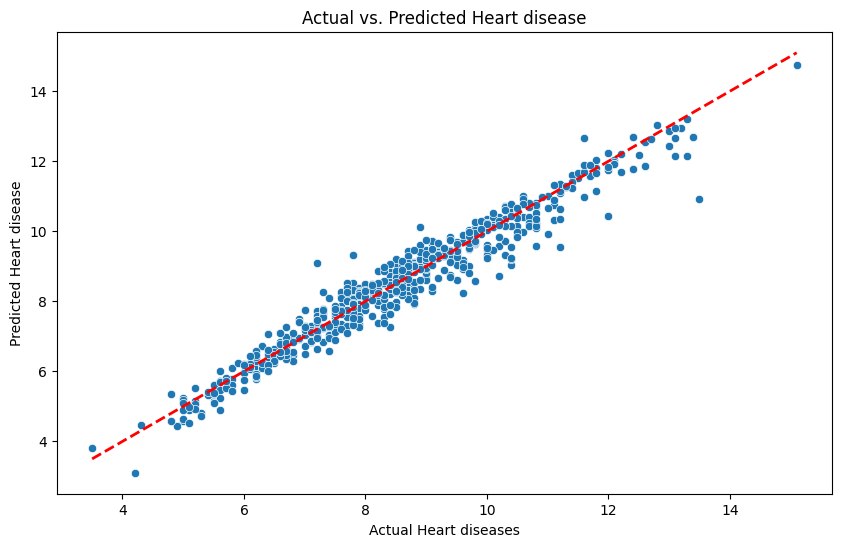

In [63]:
plt.figure(figsize= (10, 6))
sns.scatterplot(x= y_test.flatten() if hasattr(y_test, 'flatten') else y_test, y= y_test_pred.flatten())
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth= 2)
plt.title('Actual vs. Predicted Heart disease')
plt.xlabel('Actual Heart diseases')
plt.ylabel('Predicted Heart disease')
plt.show()

### 8.2.1 Conclusion Insurance Cost Prediction Model
- R^2 score of 0.94 on **the training data**.
- The R^2 score is 0.95, which is quite good **for the test set**. 95% of the variance in heart disease across the counties.
- **Chronic_Disease_Load (Weight: 0.85)**: most dominant variable. A 1% increase in the combined CKD/COPD score leads to a 0.85% increase in heart disease prevalence. This confirms the feature engineering was a success.
- **Mean Absolute Error (0.31)**: This is a very "tight" error margin. On average, the model's prediction is only 0.31 percentage points off from the actual prevalence.
- **The chart**: Actual vs. Predicted Plot, it confirms that the Linear Regression is performing with high precision.

# Step 9. Regularized Linear Models
- Because these models are sensitive to the scale of the data, I will use the scaled datasets (X_train_WITH_outliers_scal) built inprevious steps.

In [64]:
# 1. Initialize models (alpha=1.0 is the standard starting penalty)
ridge = Ridge(alpha= 1.0)
lasso = Lasso(alpha= 1.0)

# 2. Fit models on SCALED data
ridge.fit(X_train_WITH_outliers_scal, y_train)
lasso.fit(X_train_WITH_outliers_scal, y_train)

# 3. Evaluate R2 Scores
ridge_r2 = r2_score(y_test, ridge.predict(X_test_WITH_outliers_scal))
lasso_r2 = r2_score(y_test, lasso.predict(X_test_WITH_outliers_scal))

print(f"Ridge R2 Score: {ridge_r2:.4f}")
print(f"Lasso R2 Score: {lasso_r2:.4f}")

Ridge R2 Score: 0.9455
Lasso R2 Score: -0.0010


## 9.1 Inspecting the "Logic" (Weights)

In [65]:
# Create a comparison table for the weights
weights_comp = pd.DataFrame({
    'Feature': X_train_WITH_outliers_scal.columns,
    'Ridge_Weight': ridge.coef_.flatten(),
    'Lasso_Weight': lasso.coef_.flatten()
})

print("\n--- Weight Comparison ---")
print(weights_comp.sort_values(by='Lasso_Weight', ascending=False))


--- Weight Comparison ---
                                             Feature  Ridge_Weight  \
0                     Percent of Population Aged 60+      5.596332   
1                                 Obesity_prevalence      1.023526   
2  Percent of adults with a bachelor's degree or ...     -0.647119   
3                       Median_Household_Income_2018     -1.464997   
4                               Chronic_Disease_Load      7.213175   

   Lasso_Weight  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  


## 9.2 Code for RidgeCV and LassoCV

In [66]:
# 1. Define a range of alphas to test (from very small to very large)
alphas = np.logspace(-2, 4, 50) 

# 2. Initialize the Cross-Validation models
ridge_cv = RidgeCV(alphas= alphas, scoring='r2')
lasso_cv = LassoCV(alphas= alphas, cv= 5, random_state= 10)

# 3. Fit on the SCALED data
ridge_cv.fit(X_train_WITH_outliers_scal, y_train.values.ravel())
lasso_cv.fit(X_train_WITH_outliers_scal, y_train.values.ravel())

print(f"Best Ridge Alpha: {ridge_cv.alpha_}")
print(f"Best Lasso Alpha: {lasso_cv.alpha_}")

# 4. Compare the new weights
weights_cv = pd.DataFrame({
    'Feature': X_train_WITH_outliers_scal.columns,
    'RidgeCV_Weight': ridge_cv.coef_.flatten(),
    'LassoCV_Weight': lasso_cv.coef_.flatten()
})

print("\n--- Optimized Weight Comparison ---")
print(weights_cv.sort_values(by='LassoCV_Weight', ascending=False))

Best Ridge Alpha: 0.023299518105153717
Best Lasso Alpha: 0.01

--- Optimized Weight Comparison ---
                                             Feature  RidgeCV_Weight  \
4                               Chronic_Disease_Load        7.392365   
0                     Percent of Population Aged 60+        5.767681   
1                                 Obesity_prevalence        1.047421   
2  Percent of adults with a bachelor's degree or ...       -0.517842   
3                       Median_Household_Income_2018       -1.368276   

   LassoCV_Weight  
4        8.001602  
0        4.653185  
1        0.452627  
2       -0.441734  
3       -0.501636  


## 9.3 The Final Performance Report

In [67]:
# Dictionary to store results
results = {}

# List of models and their corresponding test sets
eval_list = [
    ("Linear (Original)", models[0], X_test_WITH_outliers),
    ("Ridge (Alpha= 1)", ridge, X_test_WITH_outliers_scal),
    ("Lasso (Alpha= 1)", lasso, X_test_WITH_outliers_scal),
    ("Ridge CV (Optimized)", ridge_cv, X_test_WITH_outliers_scal),
    ("Lasso CV (Optimized)", lasso_cv, X_test_WITH_outliers_scal)
]

for name, model, X_test_data in eval_list:
    y_pred = model.predict(X_test_data)
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = {"R2": round(r2, 4), "MAE ($)": round(mae, 2)}

# Convert to DataFrame for a clean display
final_comparison = pd.DataFrame(results).T
print(final_comparison)

                          R2  MAE ($)
Linear (Original)     0.9452     0.31
Ridge (Alpha= 1)      0.9455     0.31
Lasso (Alpha= 1)     -0.0010     1.42
Ridge CV (Optimized)  0.9453     0.31
Lasso CV (Optimized)  0.9433     0.32


### 9.3.1 Final Conclusions
- Linear & Ridge (The Successes): Both the Original Linear model and the Ridge models (Standard and CV) achieved an R^2 of ~0.945. This high score, combined with the low MAE of 0.31, proves the feature engineering was highly effective. 
- The Lasso Failure (R^2 of -0.0010): This is an example of over-regularization. Lasso (L1) has a "penalty" that forces coefficients to zero. 
- Lasso CV (The Recovery): Notice how Lasso CV jumped back up to 0.9433. This is because the Cross-Validation process automatically found a much smaller Alpha, preventing the model from zeroing out the important variables like Chronic_Disease_Load.